In [1]:
import os
import gc
from typing import Tuple
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pydicom
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
)
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
SERIES_DIR = "/kaggle/input/rsna-intracranial-aneurysm-detection/series"
TRAIN_CSV = "/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv"
OUTPUT_MODEL = "/kaggle/working/model_final.pth"

NUM_EPOCHS = 10          
BATCH_SIZE = 8           
LR = 1e-3
TARGET_SIZE = (64, 64, 64)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]
NUM_CLASSES = len(LABEL_COLS)
print(NUM_CLASSES)

14


In [3]:
class DICOMProcessor:
    """Loader for a DICOM series -> 3D numpy volume (D, H, W)."""
    def __init__(self, target_size: Tuple[int,int,int]=TARGET_SIZE):
        self.target_size = target_size

    def load_dicom_series(self, series_path: str) -> np.ndarray:
        if not os.path.exists(series_path):
            return np.zeros(self.target_size, dtype=np.float32)

        dicom_files = []
        for root, _, files in os.walk(series_path):
            for fname in files:
                if fname.lower().endswith('.dcm') or fname.lower().endswith('.ima'):
                    dicom_files.append(os.path.join(root, fname))
        if not dicom_files:
            all_files = [os.path.join(series_path, f) for f in os.listdir(series_path)]
            dicom_files = [f for f in all_files if os.path.isfile(f)]
        if not dicom_files:
            return np.zeros(self.target_size, dtype=np.float32)

        dicoms = []
        for fp in dicom_files:
            try:
                ds = pydicom.dcmread(fp, force=True)
                if hasattr(ds, "PixelData"):
                    inst = getattr(ds, "InstanceNumber", None)
                    try:
                        inst = int(inst) if inst is not None else None
                    except Exception:
                        inst = None
                    dicoms.append((inst, ds))
            except Exception:
                continue

        if not dicoms:
            return np.zeros(self.target_size, dtype=np.float32)

        dicoms_sorted = sorted(dicoms, key=lambda x: (x[0] is None, x[0] if x[0] is not None else 0))
        slices = []
        for _, ds in dicoms_sorted:
            try:
                arr = ds.pixel_array.astype(np.float32)
                slope = float(getattr(ds, "RescaleSlope", 1.0))
                intercept = float(getattr(ds, "RescaleIntercept", 0.0))
                arr = arr * slope + intercept
                slices.append(arr)
            except Exception:
                continue

        if not slices:
            return np.zeros(self.target_size, dtype=np.float32)

        vol = np.stack(slices, axis=0)
        vol = self.preprocess_volume(vol)
        return vol

    def preprocess_volume(self, volume):
        if volume.ndim == 4:
            volume = np.squeeze(volume)
        elif volume.ndim == 2:
            volume = np.expand_dims(volume, axis=0)

        vmin, vmax = np.percentile(volume, (1, 99))
        volume = np.clip(volume, vmin, vmax)
        volume = (volume - vmin) / (vmax - vmin + 1e-8)

        if volume.shape != self.target_size:
            while len(volume.shape) < 3:
                volume = np.expand_dims(volume, axis=0)
            zoom_factors = [self.target_size[i] / volume.shape[i] for i in range(3)]
            volume = ndimage.zoom(volume, zoom_factors, order=1)

        return volume.astype(np.float32)


In [4]:
class VolumePreprocessor:
    """Preprocessing + augmentation."""
    def __init__(self, target_size=TARGET_SIZE, is_training=True):
        self.target_size = target_size
        self.is_training = is_training

    def preprocess(self, volume: np.ndarray) -> np.ndarray:
        vol = volume.copy().astype(np.float32)
        if self.is_training:
            vol = self.augment(vol)
        vol = np.clip(vol, 0.0, 1.0)
        return vol

    def augment(self, vol: np.ndarray) -> np.ndarray:
        if random.random() < 0.5:
            if random.random() < 0.5:
                vol = np.flip(vol, axis=1)
            if random.random() < 0.5:
                vol = np.flip(vol, axis=2)
            if random.random() < 0.5:
                vol = np.flip(vol, axis=0)
            vol = vol.copy()

        if random.random() < 0.3:
            angle = random.uniform(-10, 10)
            axes = random.choice([(1,2), (0,1), (0,2)])
            vol = ndimage.rotate(vol, angle, axes=axes, reshape=False, order=1, mode='nearest')

        if random.random() < 0.3:
            scale = random.uniform(0.9, 1.1)
            shift = random.uniform(-0.05, 0.05)
            vol = vol * scale + shift

        if random.random() < 0.2:
            vol = vol + np.random.normal(0, 0.02, size=vol.shape)

        if random.random() < 0.2:
            zf = random.uniform(0.9, 1.1)
            vol = ndimage.zoom(vol, zf, order=1)
            vol = self._crop_or_pad(vol, self.target_size)

        return vol

    def _crop_or_pad(self, arr, target_shape):
        out = np.zeros(target_shape, dtype=np.float32)
        d_min = min(arr.shape[0], target_shape[0])
        h_min = min(arr.shape[1], target_shape[1])
        w_min = min(arr.shape[2], target_shape[2])
        d0 = (target_shape[0] - d_min) // 2
        h0 = (target_shape[1] - h_min) // 2
        w0 = (target_shape[2] - w_min) // 2
        sd = (arr.shape[0] - d_min) // 2
        sh = (arr.shape[1] - h_min) // 2
        sw = (arr.shape[2] - w_min) // 2
        out[d0:d0+d_min, h0:h0+h_min, w0:w0+w_min] = arr[sd:sd+d_min, sh:sh+h_min, sw:sw+w_min]
        return out

In [5]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(2)

        self.conv4 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(128)
        self.pool4 = nn.MaxPool3d(2)

        self.adaptive_pool = nn.AdaptiveAvgPool3d((2,2,2))
        self.fc1 = nn.Linear(128 * 2 * 2 * 2, 256)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x

In [6]:
class AneurysmDataset(Dataset):
    def __init__(self, df: pd.DataFrame, series_dir: str,
                 dicom_processor: DICOMProcessor,
                 preprocessor: VolumePreprocessor,
                 is_training=True):
        self.df = df.reset_index(drop=True)
        self.series_dir = series_dir
        self.dp = dicom_processor
        self.pre = preprocessor
        self.is_training = is_training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        series_id = str(row.get('SeriesInstanceUID', row.get('series_id', 'missing_series')))
        series_path = os.path.join(self.series_dir, series_id)

        vol = self.dp.load_dicom_series(series_path)
        vol = self.pre.preprocess(vol)

        vol = vol.astype(np.float32)
        vol_tensor = torch.from_numpy(vol).unsqueeze(0)  # (1, D, H, W)

        if all(col in self.df.columns for col in LABEL_COLS):
            labels = row[LABEL_COLS].values.astype(np.float32)
        else:
            labels = np.zeros(NUM_CLASSES, dtype=np.float32)
        labels_tensor = torch.from_numpy(labels)

        return vol_tensor, labels_tensor


In [7]:
def load_df(csv_path: str, series_dir: str, n_samples=1000):
    df = pd.read_csv(csv_path)
    if 'SeriesInstanceUID' in df.columns:
        df = df.sample(frac=0.15, random_state=42).reset_index(drop=True)
        
    return df

In [8]:
def calculate_metrics(labels, preds, split_name="Validation", threshold=0.5):
    metrics = {}
    preds_binary = (preds >= threshold).astype(int)

    metrics['accuracy'] = accuracy_score(labels.ravel(), preds_binary.ravel())
    metrics['f1_macro'] = f1_score(labels, preds_binary, average='macro', zero_division=0)
    metrics['f1_micro'] = f1_score(labels, preds_binary, average='micro', zero_division=0)
    metrics['recall_macro'] = recall_score(labels, preds_binary, average='macro', zero_division=0)
    metrics['precision_macro'] = precision_score(labels, preds_binary, average='macro', zero_division=0)

    # ROC-AUC macro/micro
    try:
        metrics['roc_auc_macro'] = roc_auc_score(labels, preds, average='macro')
    except ValueError as e:
        print(f"  [Warning] {split_name}: macro ROC-AUC not defined: {e}")
        metrics['roc_auc_macro'] = np.nan

    try:
        metrics['roc_auc_micro'] = roc_auc_score(labels, preds, average='micro')
    except ValueError as e:
        print(f"  [Warning] {split_name}: micro ROC-AUC not defined: {e}")
        metrics['roc_auc_micro'] = np.nan

    # Per-class ROC-AUC
    metrics['roc_auc_per_class'] = {}
    for i, label_name in enumerate(LABEL_COLS):
        try:
            unique_labels = np.unique(labels[:, i])
            if len(unique_labels) > 1:
                auc = roc_auc_score(labels[:, i], preds[:, i])
                metrics['roc_auc_per_class'][label_name] = auc
            else:
                metrics['roc_auc_per_class'][label_name] = np.nan
        except Exception:
            metrics['roc_auc_per_class'][label_name] = np.nan

    print(f"\n--- {split_name} Metrics ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 (macro): {metrics['f1_macro']:.4f}")
    print(f"F1 (micro): {metrics['f1_micro']:.4f}")
    print(f"Recall (macro): {metrics['recall_macro']:.4f}")
    print(f"Precision (macro): {metrics['precision_macro']:.4f}")
    if not np.isnan(metrics['roc_auc_macro']):
        print(f"ROC-AUC (macro): {metrics['roc_auc_macro']:.4f}")
    else:
        print("ROC-AUC (macro): N/A")
    if not np.isnan(metrics['roc_auc_micro']):
        print(f"ROC-AUC (micro): {metrics['roc_auc_micro']:.4f}")
    else:
        print("ROC-AUC (micro): N/A")

    print("\nPer-Class ROC-AUC:")
    for label, auc in metrics['roc_auc_per_class'].items():
        if np.isnan(auc):
            print(f"  {label}: N/A (single class)")
        else:
            print(f"  {label}: {auc:.4f}")

    return metrics

In [9]:
class GradCAM3D:
    """
    Grad-CAM for 3D CNNs. Highlights spatial regions important for a given class.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        
        self.fwd_handle = target_layer.register_forward_hook(forward_hook)
        self.bwd_handle = target_layer.register_full_backward_hook(backward_hook)
    
    def __call__(self, input_tensor, class_idx):
        """
        Generate Grad-CAM heatmap for input_tensor and target class_idx.
        
        Args:
            input_tensor: (1, 1, D, H, W) torch tensor on DEVICE
            class_idx: integer index of target class
            
        Returns:
            cam_3d: (D, H, W) normalized numpy array in [0, 1]
        """
        self.model.zero_grad()
        output = self.model(input_tensor)
        
        score = output[0, class_idx]
        score.backward()
        
        grads = self.gradients
        acts = self.activations
        
        weights = grads.mean(dim=(2, 3, 4), keepdim=True)
        cam = (weights * acts).sum(dim=1)
        cam = F.relu(cam)
        cam = cam.squeeze(0)
        
        cam = F.interpolate(
            cam.unsqueeze(0).unsqueeze(0),
            size=input_tensor.shape[2:],
            mode='trilinear',
            align_corners=False
        ).squeeze().cpu().numpy()
        
        if cam.max() > cam.min():
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            cam = np.zeros_like(cam)
        
        return cam
    
    def remove_hooks(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

In [10]:
def visualize_gradcam_slices(volume, cam_3d, label_name, num_slices=4):
    """
    Overlay Grad-CAM heatmap on volume slices.
    
    Args:
        volume: (D, H, W) numpy array (original grayscale volume)
        cam_3d: (D, H, W) numpy array (Grad-CAM heatmap in [0, 1])
        label_name: string name of the class
        num_slices: number of evenly spaced slices to display
    """
    D = volume.shape[0]
    slice_indices = np.linspace(0, D-1, num_slices, dtype=int)
    
    fig, axes = plt.subplots(2, num_slices, figsize=(3*num_slices, 6))
    
    for i, slice_idx in enumerate(slice_indices):
        # Original slice
        axes[0, i].imshow(volume[slice_idx], cmap='gray')
        axes[0, i].set_title(f'Slice {slice_idx}')
        axes[0, i].axis('off')
        
        # Grad-CAM overlay
        axes[1, i].imshow(volume[slice_idx], cmap='gray')
        axes[1, i].imshow(cam_3d[slice_idx], cmap='jet', alpha=0.5)
        axes[1, i].set_title(f'Grad-CAM')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Grad-CAM for: {label_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/gradcam_{label_name.replace(" ", "_")}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [11]:
def train_val_test_pipeline():
    # 1) Load full dataframe
    df = load_df(TRAIN_CSV, SERIES_DIR)

    # 2) Split into train, val, test
    train_df, temp_df = train_test_split(
        df, test_size=0.30, random_state=42, shuffle=True
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.50, random_state=42, shuffle=True
    )

    print(f"\n{'='*60}")
    print(f"Total samples: {len(df)}")
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    print(f"{'='*60}")

    dp = DICOMProcessor(target_size=TARGET_SIZE)
    train_pre = VolumePreprocessor(target_size=TARGET_SIZE, is_training=True)
    val_pre = VolumePreprocessor(target_size=TARGET_SIZE, is_training=False)
    test_pre = VolumePreprocessor(target_size=TARGET_SIZE, is_training=False)

    train_dataset = AneurysmDataset(train_df, SERIES_DIR, dp, train_pre, is_training=True)
    val_dataset = AneurysmDataset(val_df, SERIES_DIR, dp, val_pre, is_training=False)
    test_dataset = AneurysmDataset(test_df, SERIES_DIR, dp, test_pre, is_training=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # 3) Init model
    model = Simple3DCNN(num_classes=NUM_CLASSES).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    train_losses = []
    val_losses = []

    # 4) Training loop with detailed prints
    print("\n=== Beginning Training ===")
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        i = 0

        for volumes, labels in train_loader:
            i += 1
            print(f"Epoch = {epoch+1} | Train Iter = {i} | Running Loss = {running_loss:.4f}")
            
            volumes = volumes.to(DEVICE, dtype=torch.float32)
            labels = labels.to(DEVICE, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(volumes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            del volumes, labels, outputs, loss
            if DEVICE.type == 'cuda':
                torch.cuda.empty_cache()

        avg_train_loss = running_loss / max(1, len(train_loader))
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        print(f"\n=== Beginning Validation for Epoch {epoch+1} ===")
        j = 0

        with torch.no_grad():
            for volumes, labels in val_loader:
                j += 1
                print(f"Epoch = {epoch+1} | Val Iter = {j} | Val Loss = {val_loss:.4f}")
                
                volumes = volumes.to(DEVICE, dtype=torch.float32)
                labels = labels.to(DEVICE, dtype=torch.float32)

                outputs = model(volumes)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy()
                val_preds.append(preds)
                val_labels.append(labels.cpu().numpy())

                del volumes, labels, outputs, loss
                if DEVICE.type == 'cuda':
                    torch.cuda.empty_cache()

        avg_val_loss = val_loss / max(1, len(val_loader))
        val_losses.append(avg_val_loss)

        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"{'='*60}\n")

        scheduler.step(avg_val_loss)

    # 5) Plot loss vs epoch
    print("\n=== Plotting Loss Curves ===")
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(7,5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('/kaggle/working/loss_train_val.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved loss_train_val.png")

    # 6) Metrics on validation set
    val_preds_array = np.vstack(val_preds)
    val_labels_array = np.vstack(val_labels)
    val_metrics = calculate_metrics(val_labels_array, val_preds_array, split_name="Validation")

    # 7) Save final model
    torch.save(model.state_dict(), OUTPUT_MODEL)
    print(f"\n[Info] Model saved to {OUTPUT_MODEL}")

    # 8) Test evaluation
    test_metrics = evaluate_on_test(model, test_loader)
    
    # 9) Grad-CAM visualization on a few test samples
    print("\n=== Generating Grad-CAM Visualizations ===")
    generate_gradcam_examples(model, test_dataset, num_examples=4)
    
    return val_metrics, test_metrics

In [12]:
def evaluate_on_test(model, test_loader):
    print("\n=== Beginning Test Evaluation ===")
    model.eval()
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for volumes, labels in test_loader:
            volumes = volumes.to(DEVICE, dtype=torch.float32)
            outputs = model(volumes)
            preds = torch.sigmoid(outputs).cpu().numpy()
            test_preds.append(preds)
            test_labels.append(labels.numpy())

            del volumes, labels, outputs
            if DEVICE.type == 'cuda':
                torch.cuda.empty_cache()

    test_preds_array = np.vstack(test_preds)
    test_labels_array = np.vstack(test_labels)
    test_metrics = calculate_metrics(test_labels_array, test_preds_array, split_name="Test")
    return test_metrics

In [13]:
def generate_gradcam_examples(model, dataset, num_examples=3):
    """
    Generate Grad-CAM visualizations for a few samples from dataset.
    Shows heatmaps for "Aneurysm Present" and one location-specific label.
    """
    model.eval()
    
    # Initialize Grad-CAM with last conv layer
    gradcam = GradCAM3D(model, target_layer=model.conv4)
    
    # Classes to visualize
    classes_to_viz = [
        LABEL_COLS.index("Left Infraclinoid Internal Carotid Artery"),
        LABEL_COLS.index("Right Infraclinoid Internal Carotid Artery"),
        LABEL_COLS.index("Left Supraclinoid Internal Carotid Artery"),
        LABEL_COLS.index("Right Supraclinoid Internal Carotid Artery"),
        LABEL_COLS.index("Left Middle Cerebral Artery"),
        LABEL_COLS.index("Right Middle Cerebral Artery"),
        LABEL_COLS.index("Anterior Communicating Artery"),
        LABEL_COLS.index("Left Anterior Cerebral Artery"),
        LABEL_COLS.index("Right Anterior Cerebral Artery"),
        LABEL_COLS.index("Left Posterior Communicating Artery"),
        LABEL_COLS.index("Right Posterior Communicating Artery"),
        LABEL_COLS.index("Basilar Tip"),
        LABEL_COLS.index("Other Posterior Circulation"),
        LABEL_COLS.index("Aneurysm Present")
    ]
    
    for i in range(min(num_examples, len(dataset))):
        print(f"\n=== Generating Grad-CAM for Sample {i+1}/{num_examples} ===")
        
        volume_tensor, label_tensor = dataset[i]
        volume_np = volume_tensor.squeeze(0).cpu().numpy()  # (D, H, W)
        
        # Move to device and add batch dim
        volume_input = volume_tensor.unsqueeze(0).to(DEVICE, dtype=torch.float32)  # (1, 1, D, H, W)
        
        print(f"Ground truth labels: {label_tensor.numpy()}")
        
        for class_idx in classes_to_viz:
            label_name = LABEL_COLS[class_idx]
            print(f"  Generating Grad-CAM for: {label_name}")
            
            cam_3d = gradcam(volume_input, class_idx=class_idx)
            
            # Visualize
            visualize_gradcam_slices(
                volume_np, 
                cam_3d, 
                label_name=f"{label_name}_sample_{i+1}",
                num_slices=4
            )
        
        # Clean up
        del volume_input
        if DEVICE.type == 'cuda':
            torch.cuda.empty_cache()
    
    gradcam.remove_hooks()
    print("\n=== Grad-CAM Visualization Complete ===")


Using device: cpu

Total samples: 652
Train: 456, Val: 98, Test: 98

=== Beginning Training ===
Epoch = 1 | Train Iter = 1 | Running Loss = 0.0000
Epoch = 1 | Train Iter = 2 | Running Loss = 0.7078
Epoch = 1 | Train Iter = 3 | Running Loss = 1.3282
Epoch = 1 | Train Iter = 4 | Running Loss = 1.8624
Epoch = 1 | Train Iter = 5 | Running Loss = 2.3157
Epoch = 1 | Train Iter = 6 | Running Loss = 2.6927
Epoch = 1 | Train Iter = 7 | Running Loss = 3.0288
Epoch = 1 | Train Iter = 8 | Running Loss = 3.2821
Epoch = 1 | Train Iter = 9 | Running Loss = 3.4991
Epoch = 1 | Train Iter = 10 | Running Loss = 3.7317
Epoch = 1 | Train Iter = 11 | Running Loss = 3.9633
Epoch = 1 | Train Iter = 12 | Running Loss = 4.0590
Epoch = 1 | Train Iter = 13 | Running Loss = 4.2711
Epoch = 1 | Train Iter = 14 | Running Loss = 4.6883
Epoch = 1 | Train Iter = 15 | Running Loss = 5.1532
Epoch = 1 | Train Iter = 16 | Running Loss = 5.4009
Epoch = 1 | Train Iter = 17 | Running Loss = 5.6178
Epoch = 1 | Train Iter = 18 |

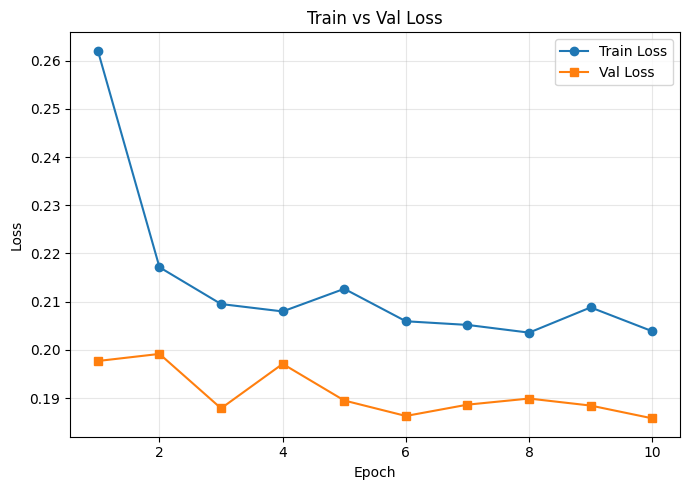

Saved loss_train_val.png
  [Warning] Validation: macro ROC-AUC not defined: Only one class present in y_true. ROC AUC score is not defined in that case.

--- Validation Metrics ---
Accuracy: 0.9380
F1 (macro): 0.0234
F1 (micro): 0.1905
Recall (macro): 0.0183
Precision (macro): 0.0325
ROC-AUC (macro): N/A
ROC-AUC (micro): 0.7873

Per-Class ROC-AUC:
  Left Infraclinoid Internal Carotid Artery: 0.4271
  Right Infraclinoid Internal Carotid Artery: 0.4839
  Left Supraclinoid Internal Carotid Artery: 0.5333
  Right Supraclinoid Internal Carotid Artery: 0.8982
  Left Middle Cerebral Artery: 0.5720
  Right Middle Cerebral Artery: 0.4728
  Anterior Communicating Artery: 0.6040
  Left Anterior Cerebral Artery: 0.7649
  Right Anterior Cerebral Artery: 0.7216
  Left Posterior Communicating Artery: 0.3229
  Right Posterior Communicating Artery: 0.6289
  Basilar Tip: N/A (single class)
  Other Posterior Circulation: 0.4688
  Aneurysm Present: 0.5776

[Info] Model saved to /kaggle/working/model_final

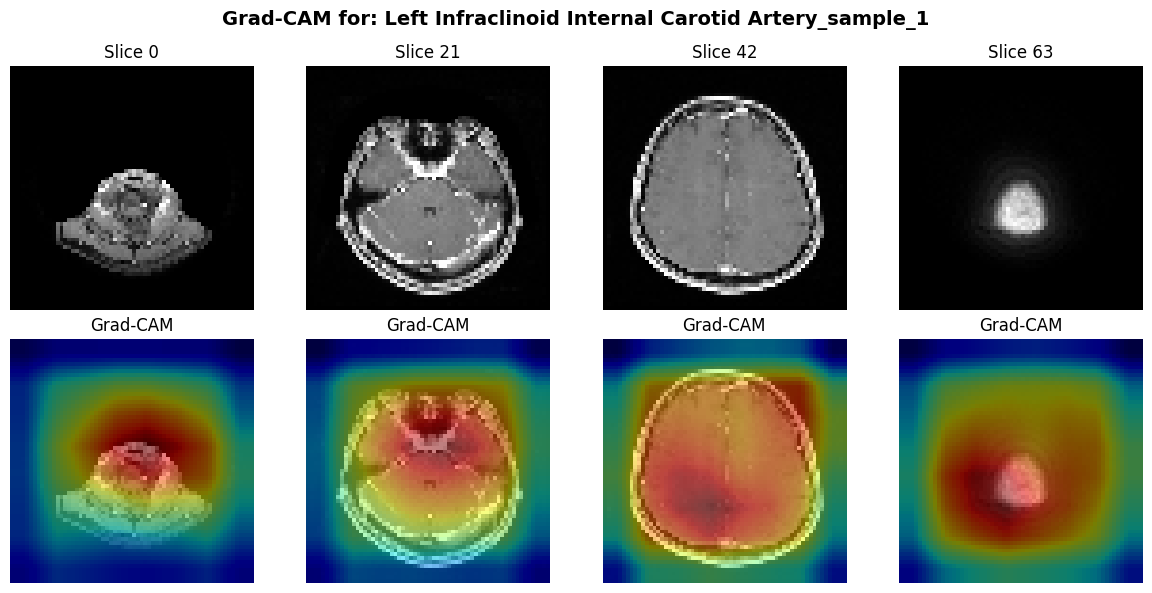

  Generating Grad-CAM for: Right Infraclinoid Internal Carotid Artery


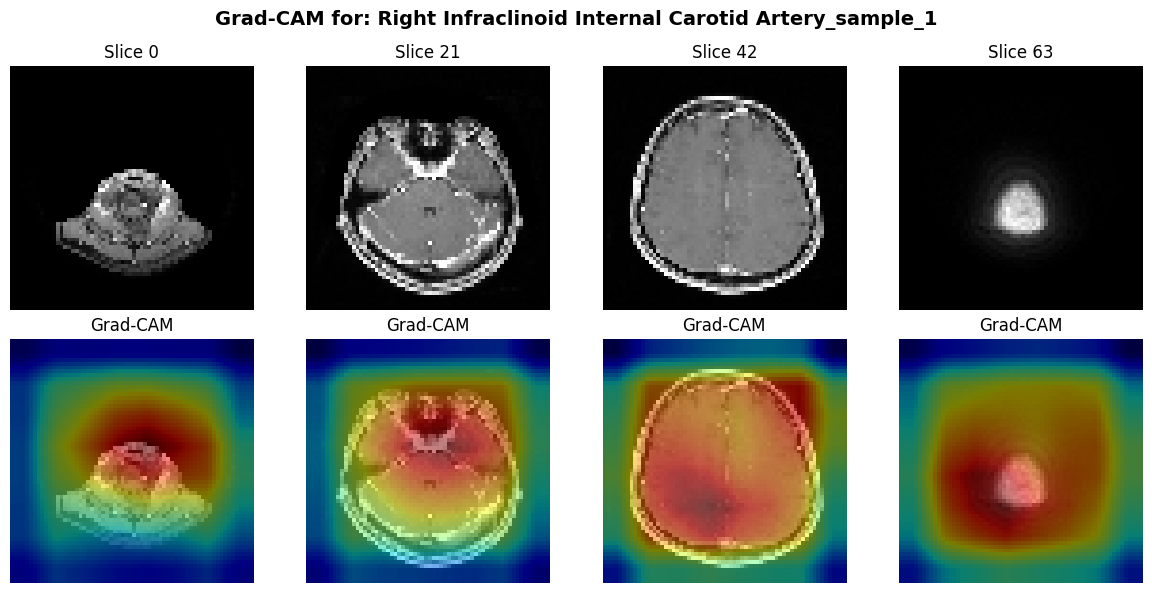

  Generating Grad-CAM for: Left Supraclinoid Internal Carotid Artery


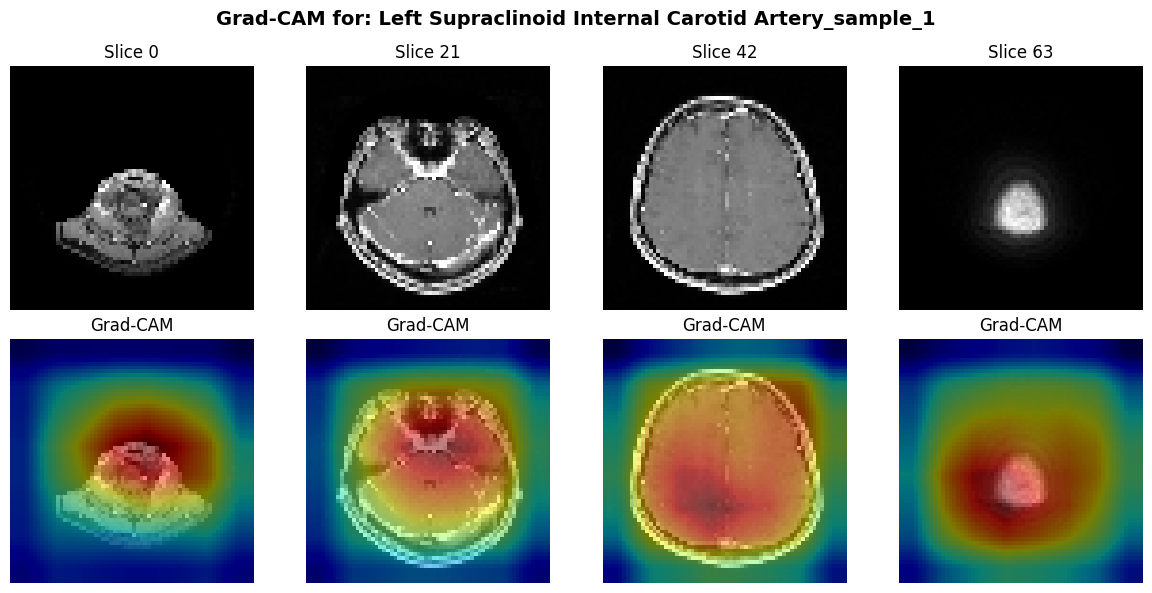

  Generating Grad-CAM for: Right Supraclinoid Internal Carotid Artery


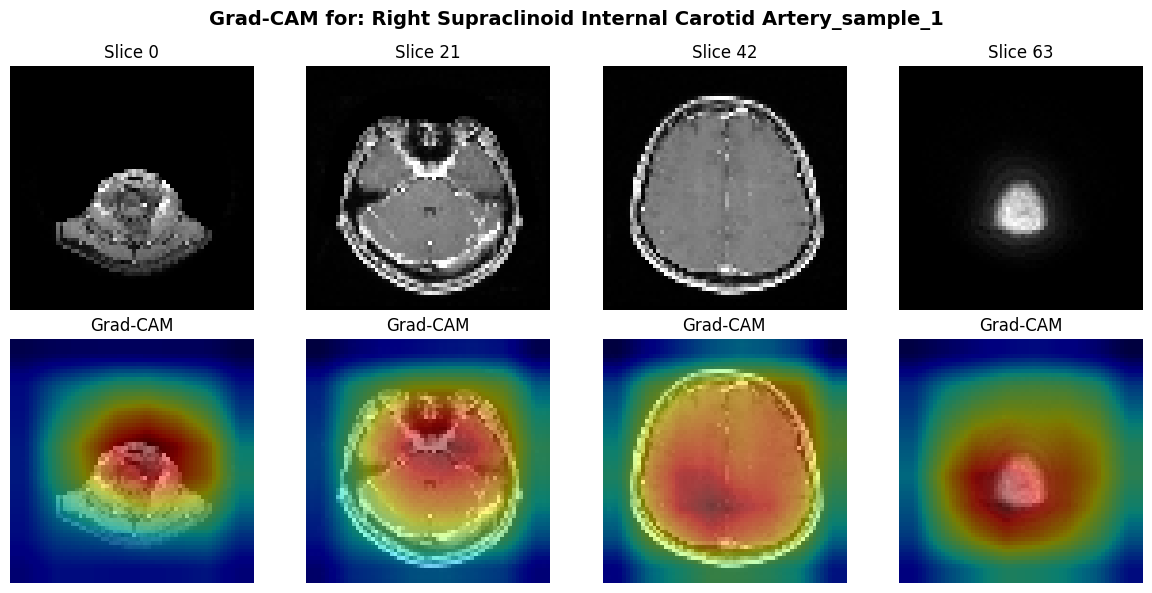

  Generating Grad-CAM for: Left Middle Cerebral Artery


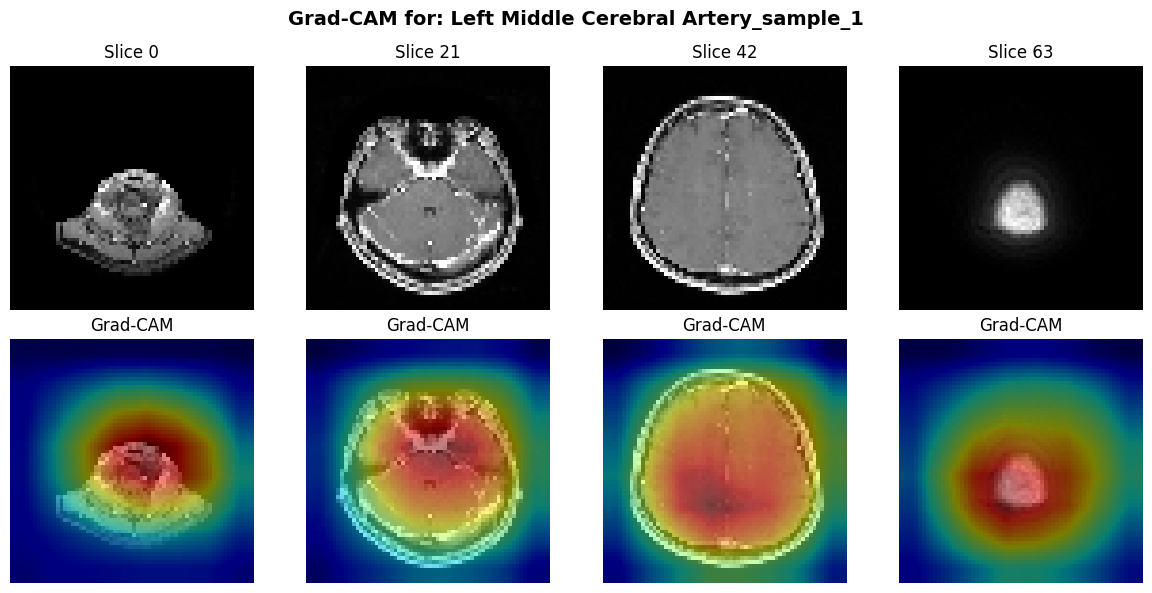

  Generating Grad-CAM for: Right Middle Cerebral Artery


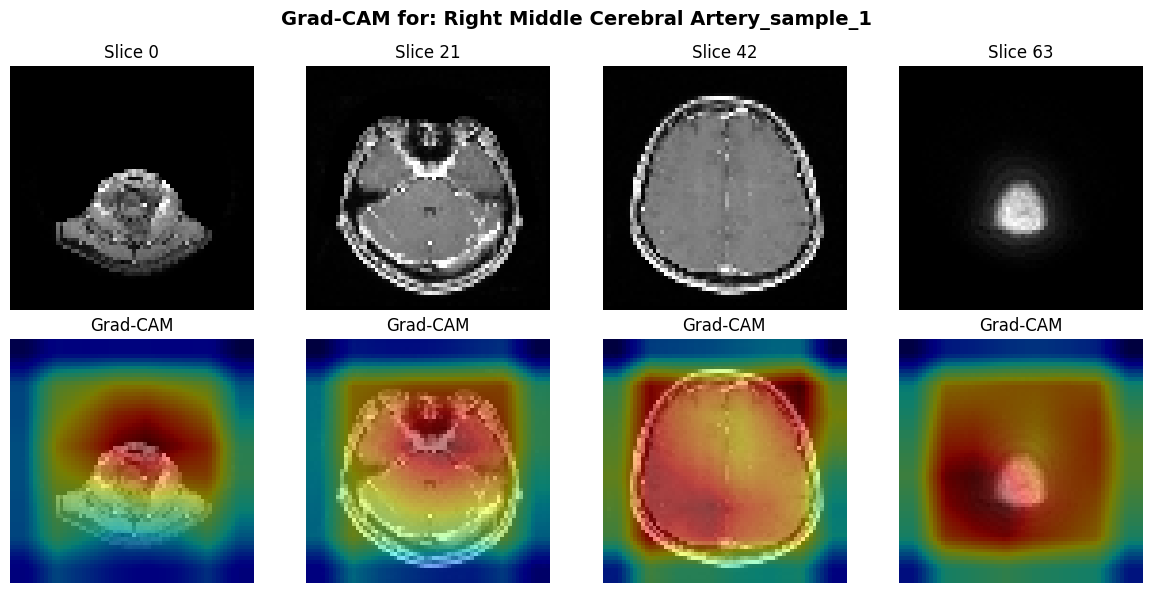

  Generating Grad-CAM for: Anterior Communicating Artery


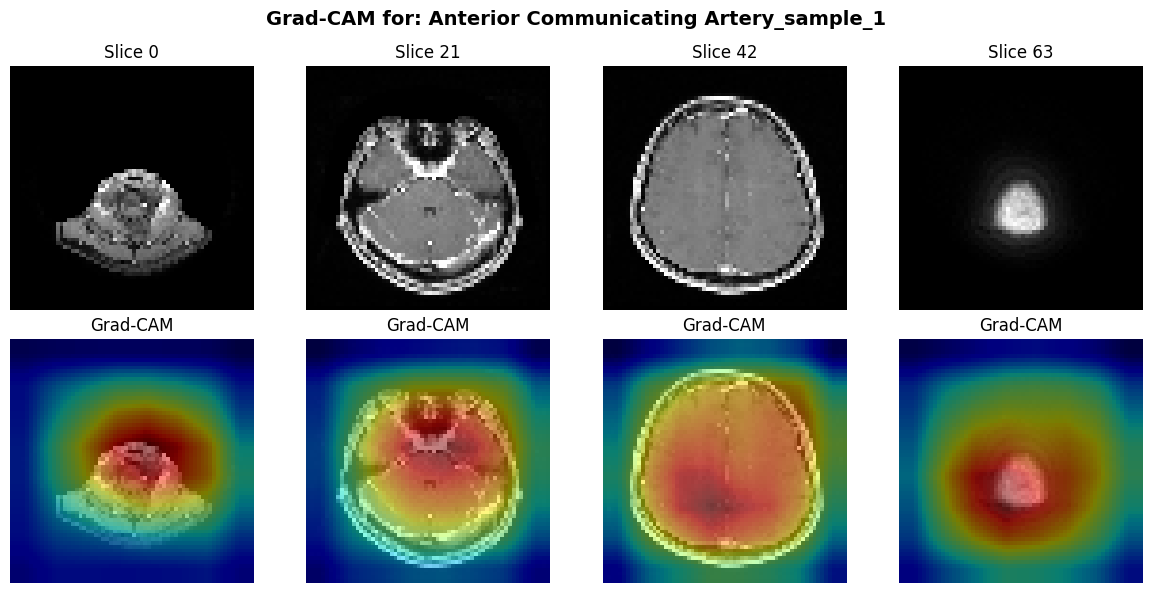

  Generating Grad-CAM for: Left Anterior Cerebral Artery


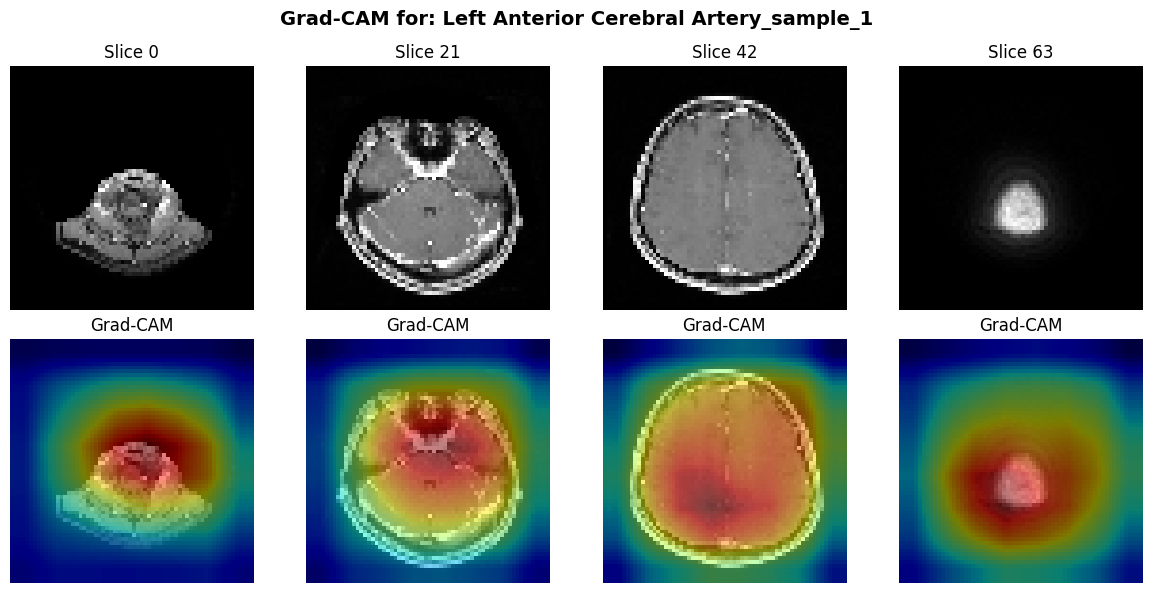

  Generating Grad-CAM for: Right Anterior Cerebral Artery


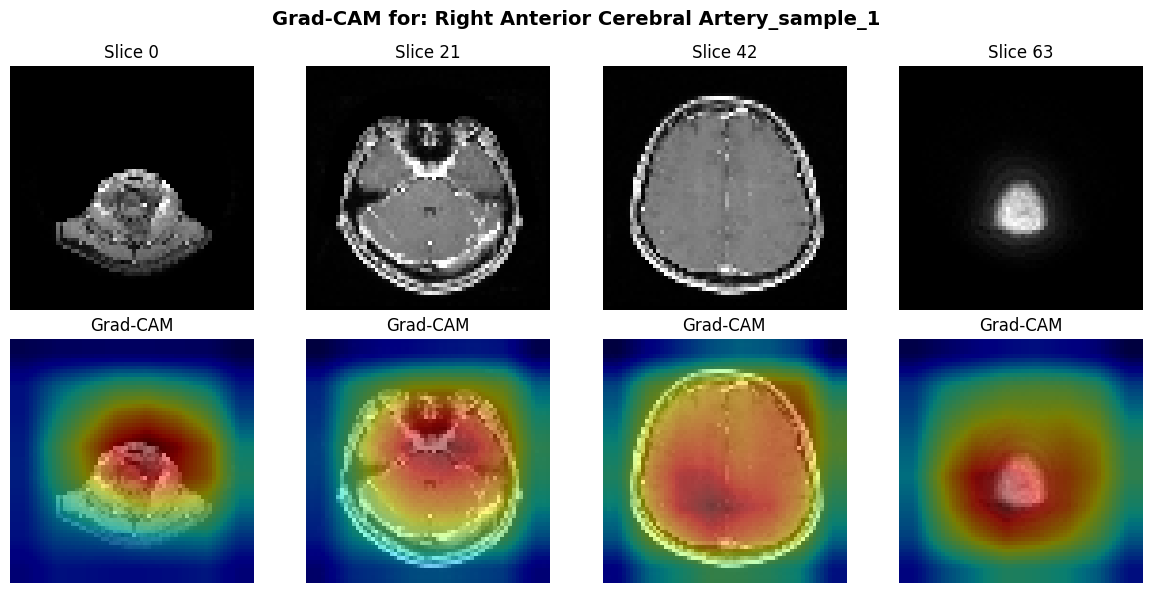

  Generating Grad-CAM for: Left Posterior Communicating Artery


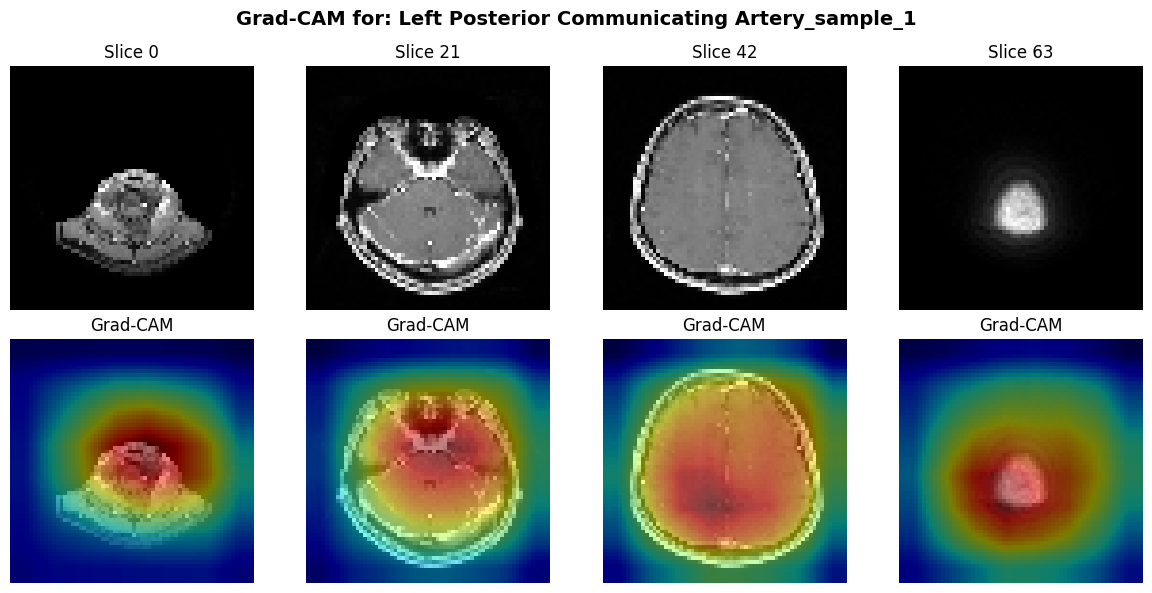

  Generating Grad-CAM for: Right Posterior Communicating Artery


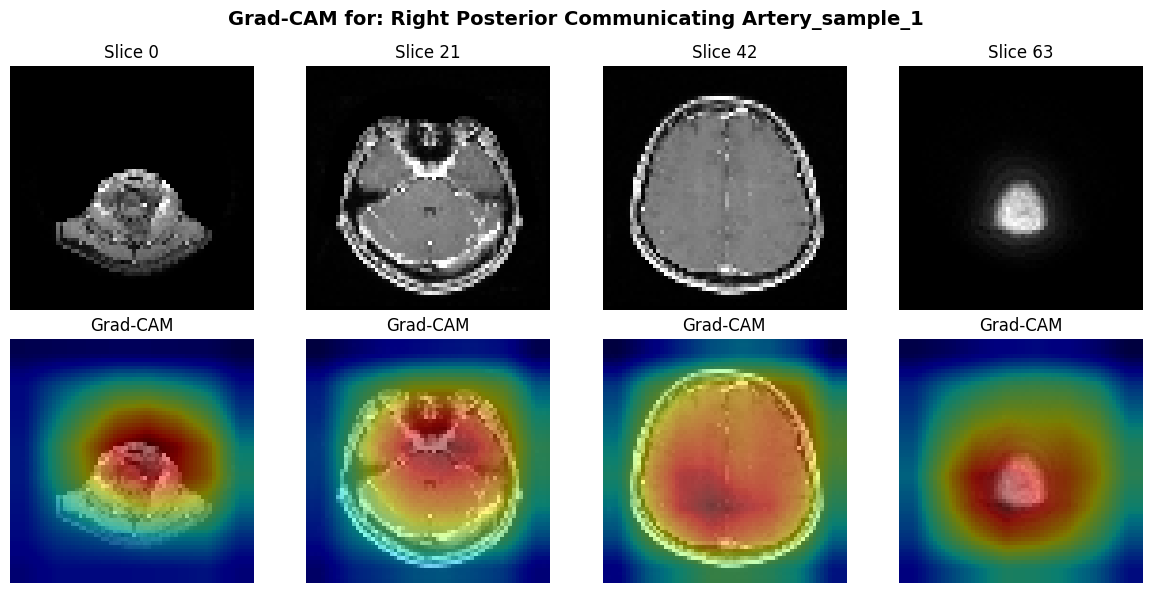

  Generating Grad-CAM for: Basilar Tip


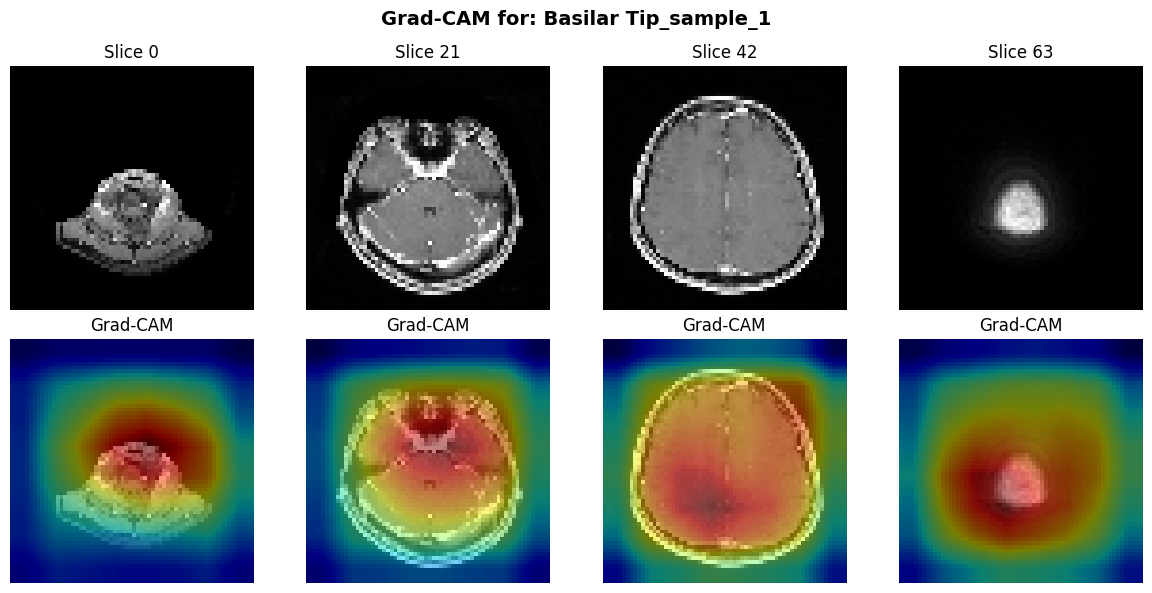

  Generating Grad-CAM for: Other Posterior Circulation


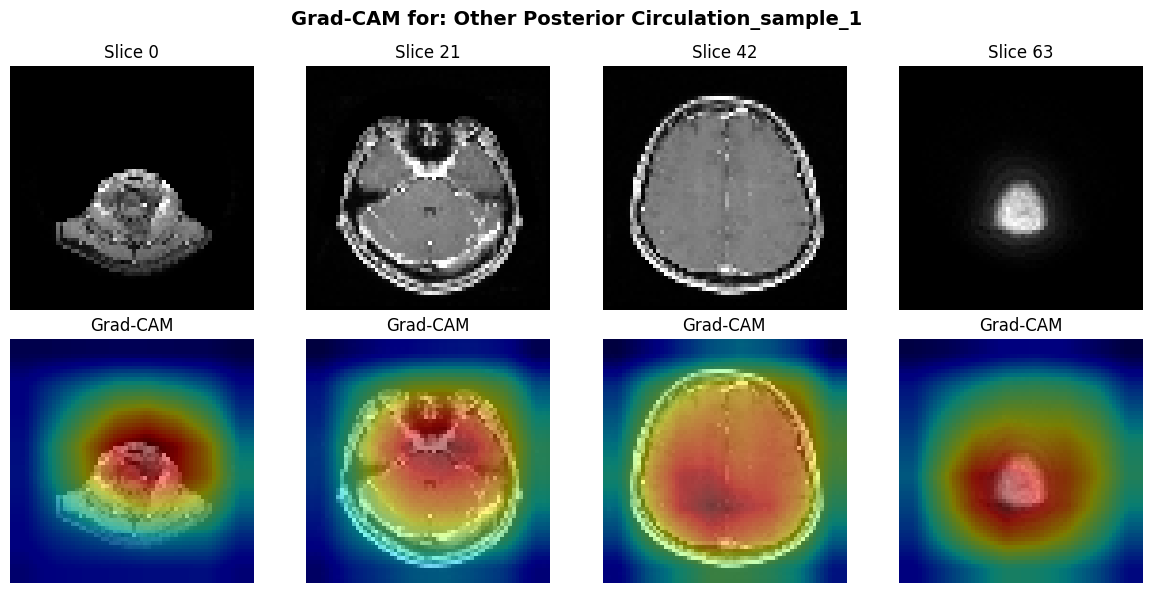

  Generating Grad-CAM for: Aneurysm Present


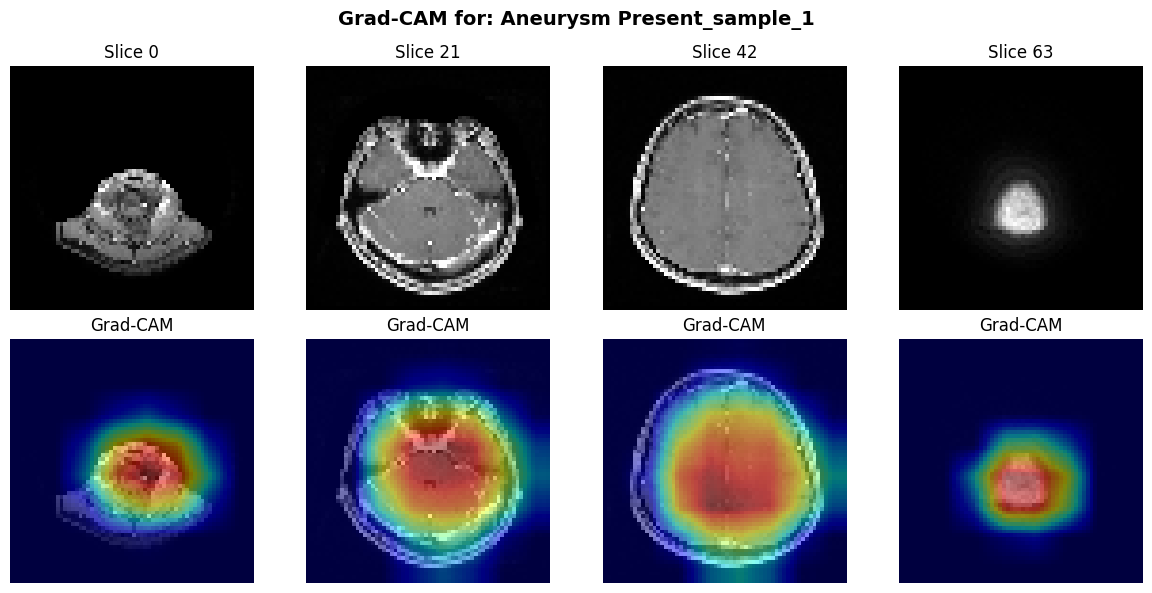


=== Generating Grad-CAM for Sample 2/4 ===
Ground truth labels: [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
  Generating Grad-CAM for: Left Infraclinoid Internal Carotid Artery


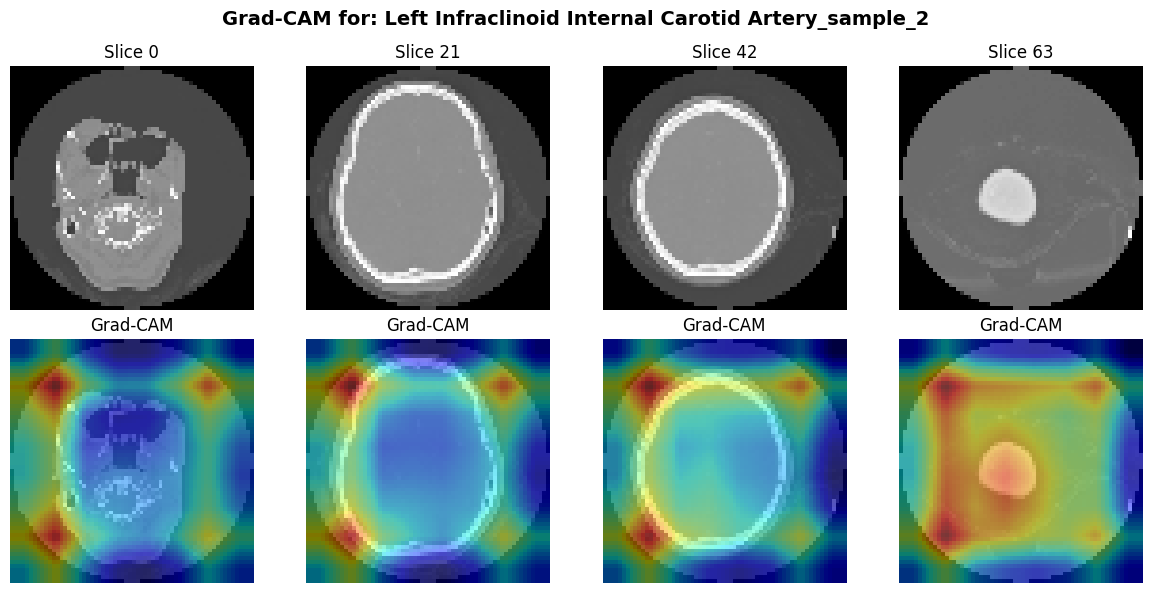

  Generating Grad-CAM for: Right Infraclinoid Internal Carotid Artery


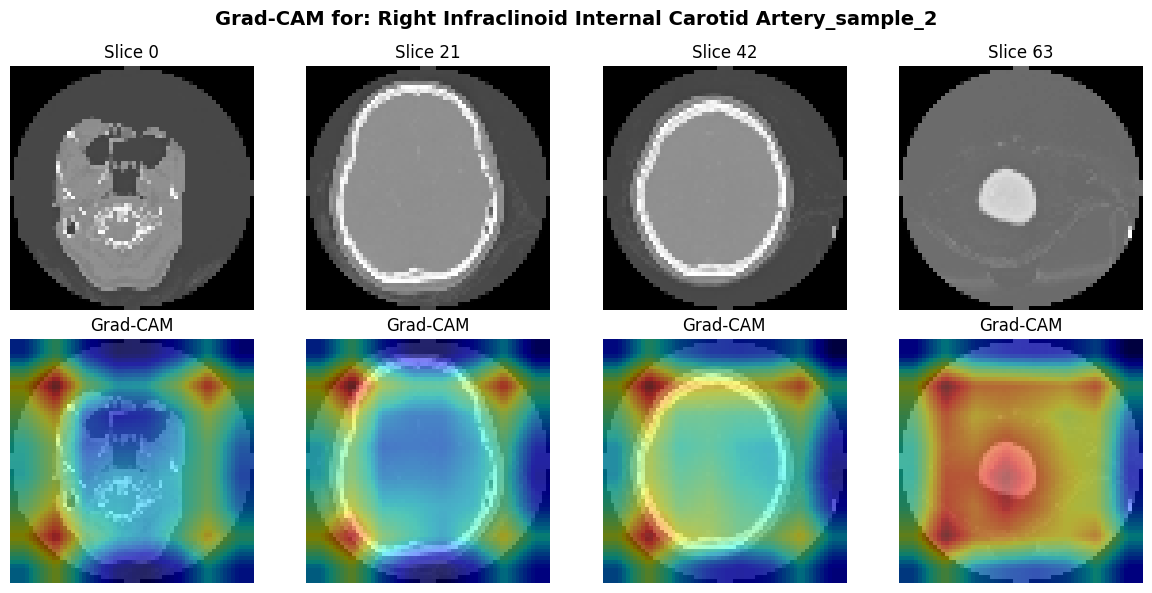

  Generating Grad-CAM for: Left Supraclinoid Internal Carotid Artery


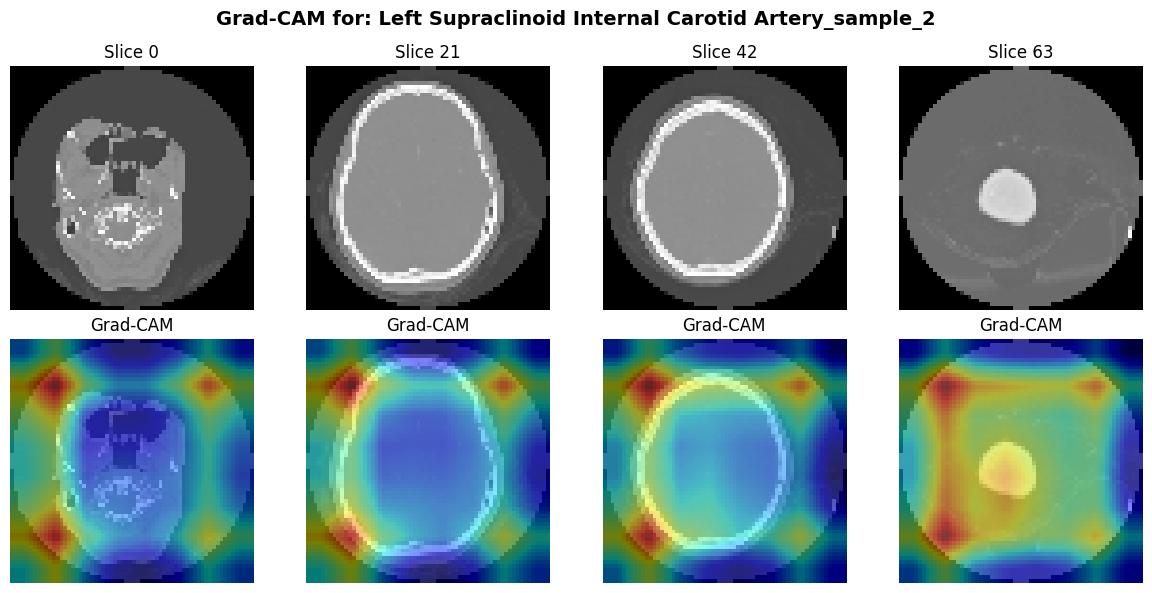

  Generating Grad-CAM for: Right Supraclinoid Internal Carotid Artery


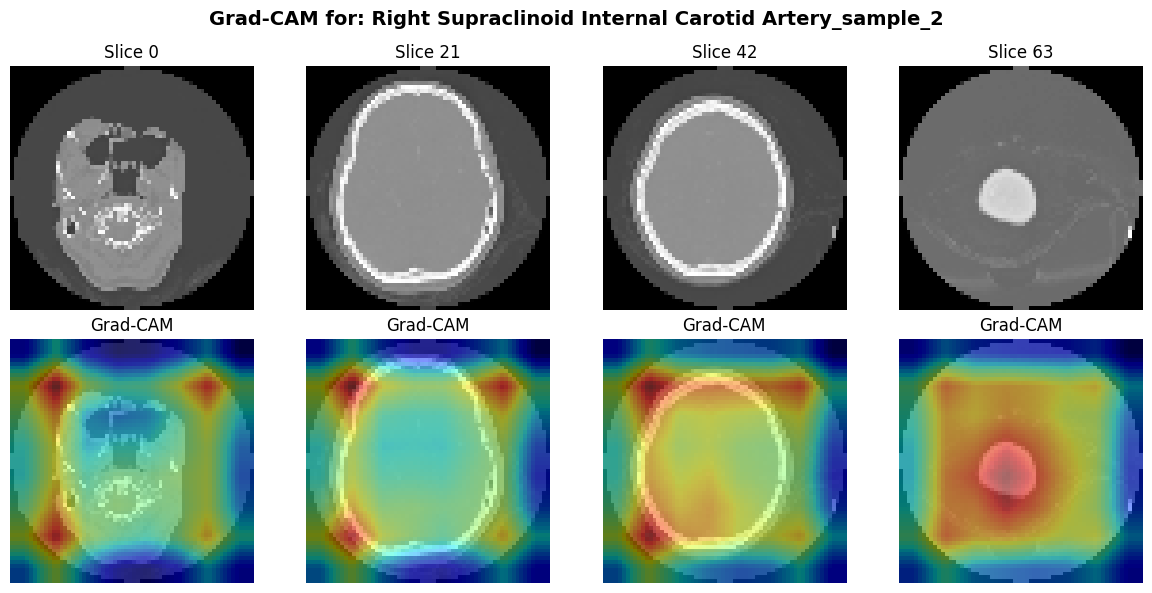

  Generating Grad-CAM for: Left Middle Cerebral Artery


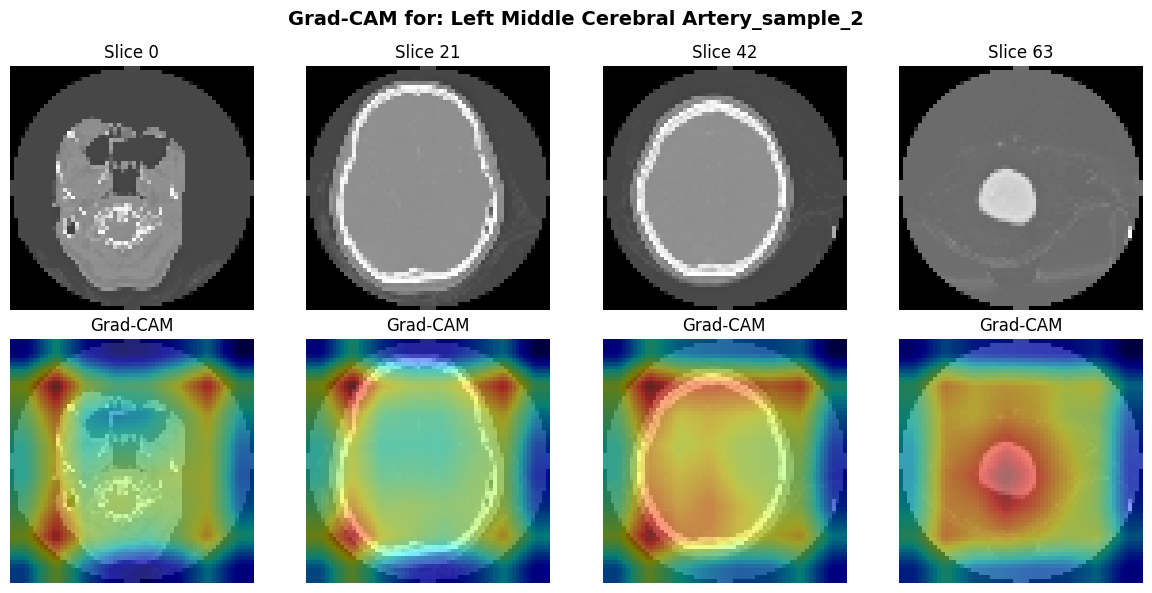

  Generating Grad-CAM for: Right Middle Cerebral Artery


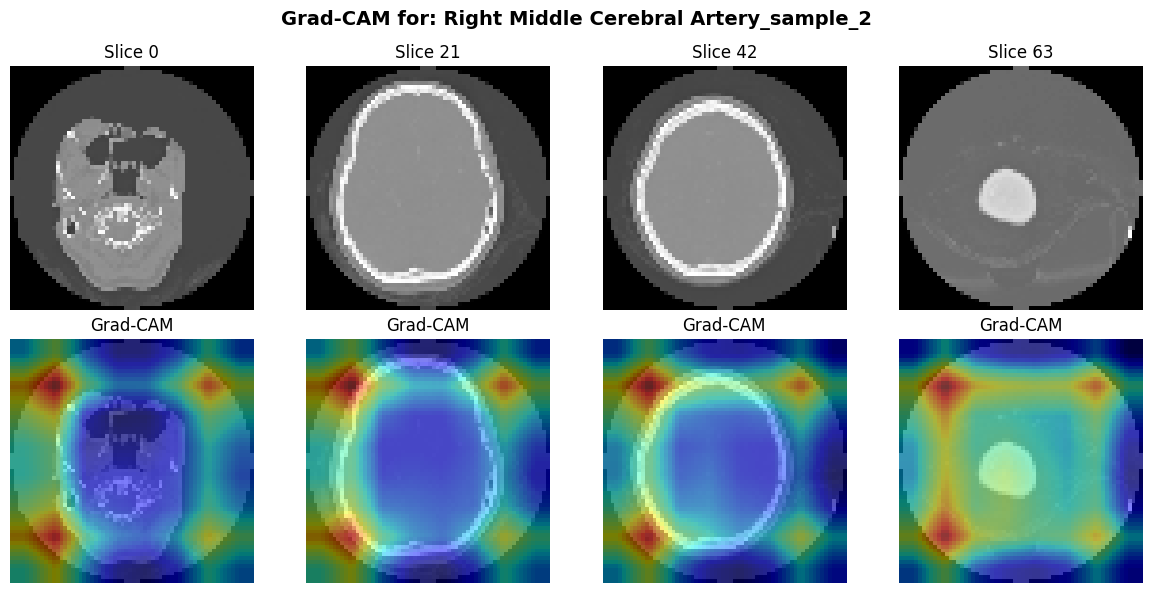

  Generating Grad-CAM for: Anterior Communicating Artery


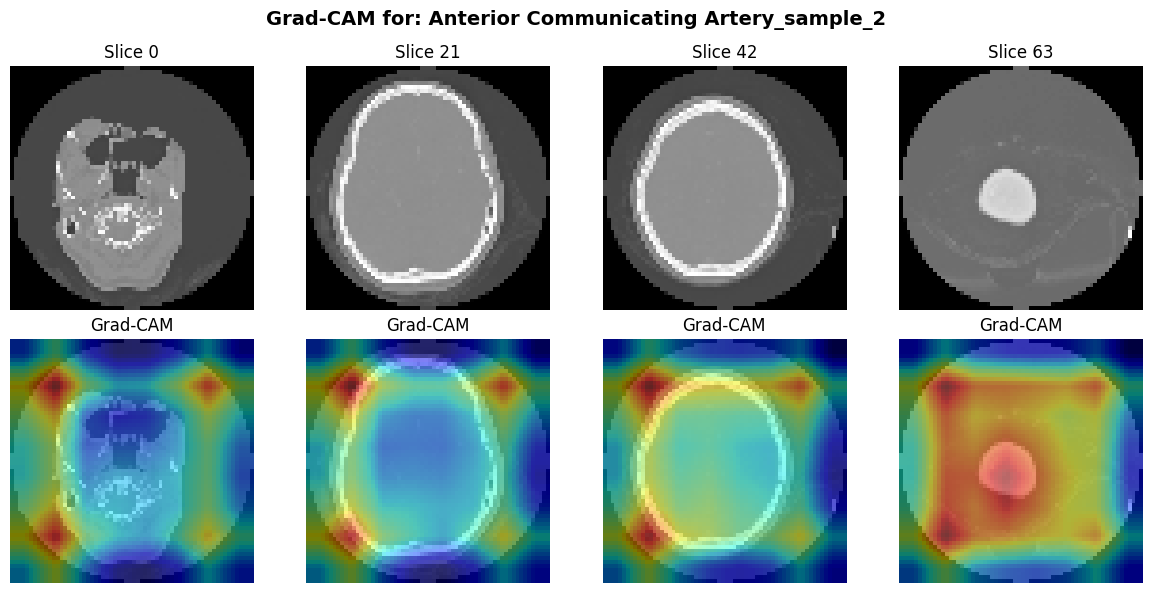

  Generating Grad-CAM for: Left Anterior Cerebral Artery


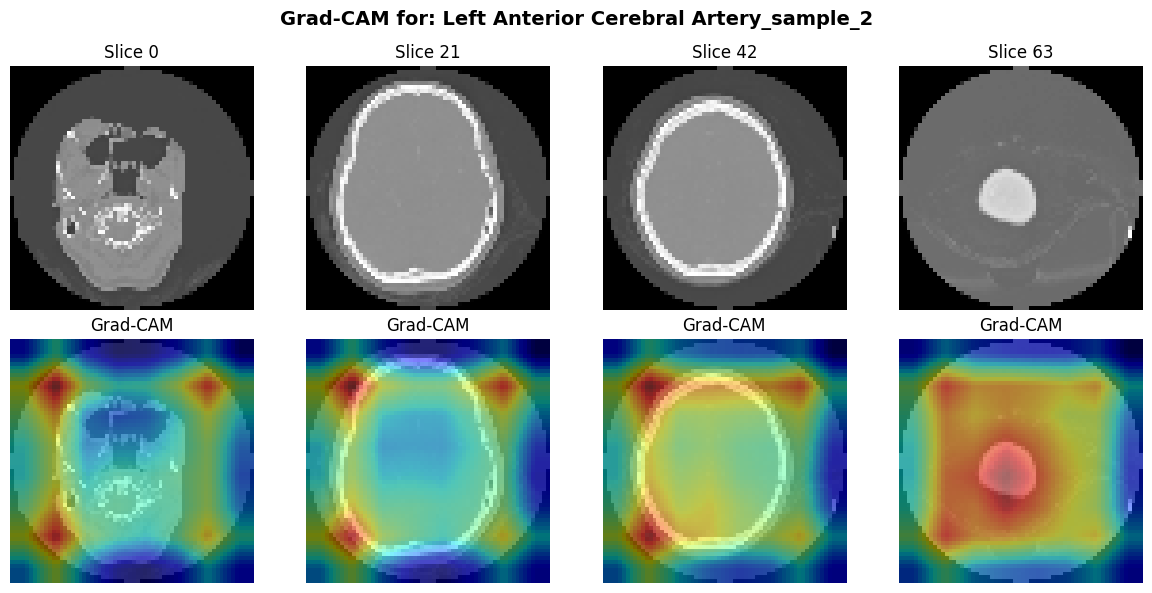

  Generating Grad-CAM for: Right Anterior Cerebral Artery


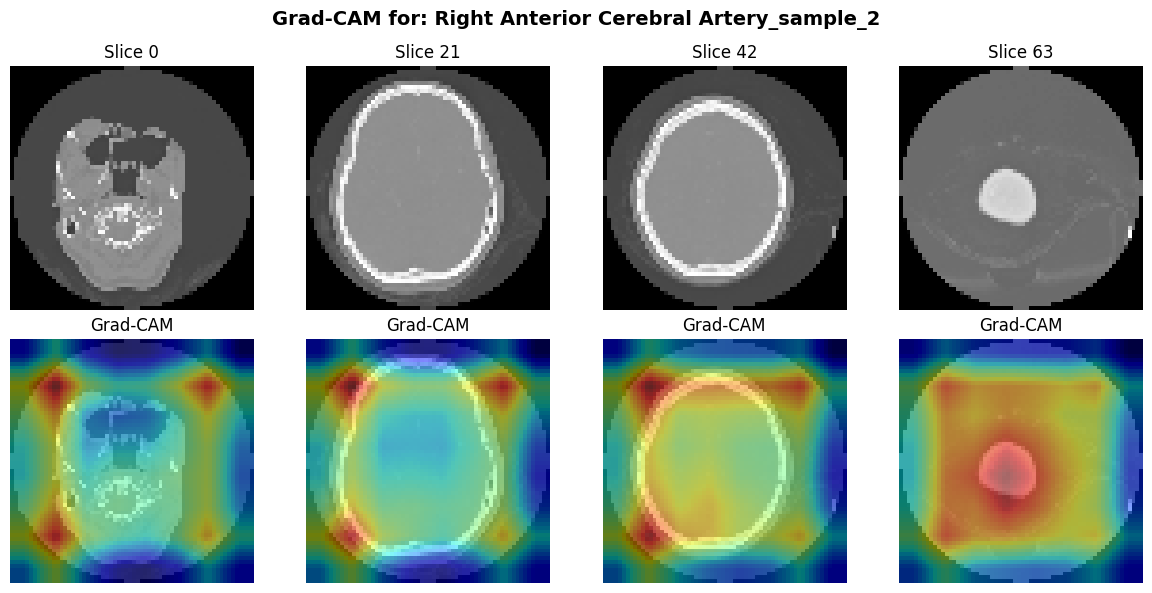

  Generating Grad-CAM for: Left Posterior Communicating Artery


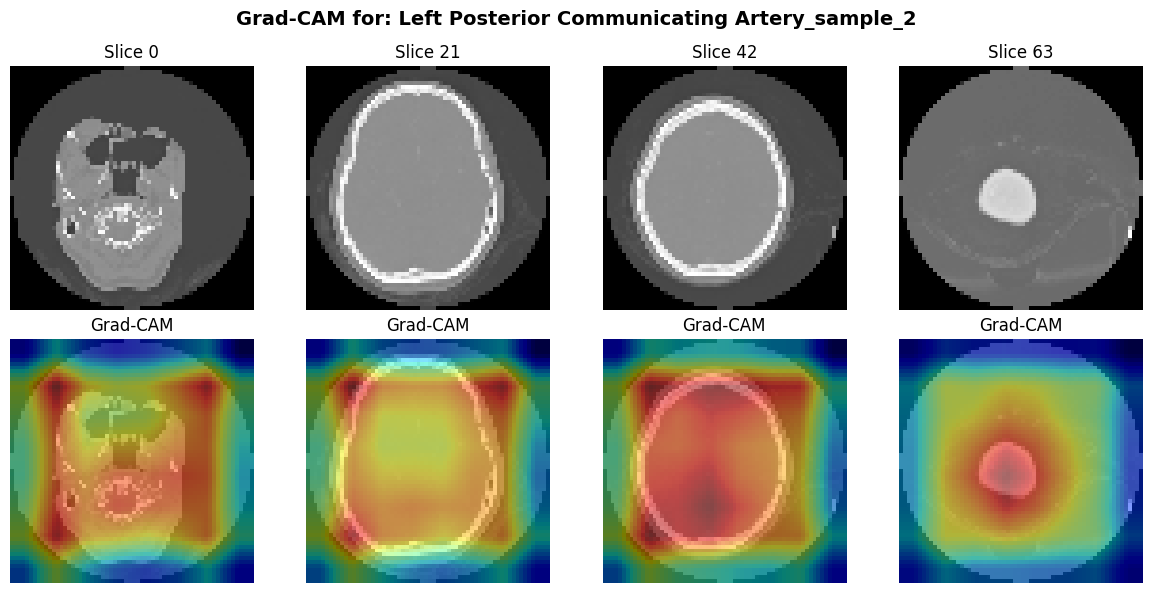

  Generating Grad-CAM for: Right Posterior Communicating Artery


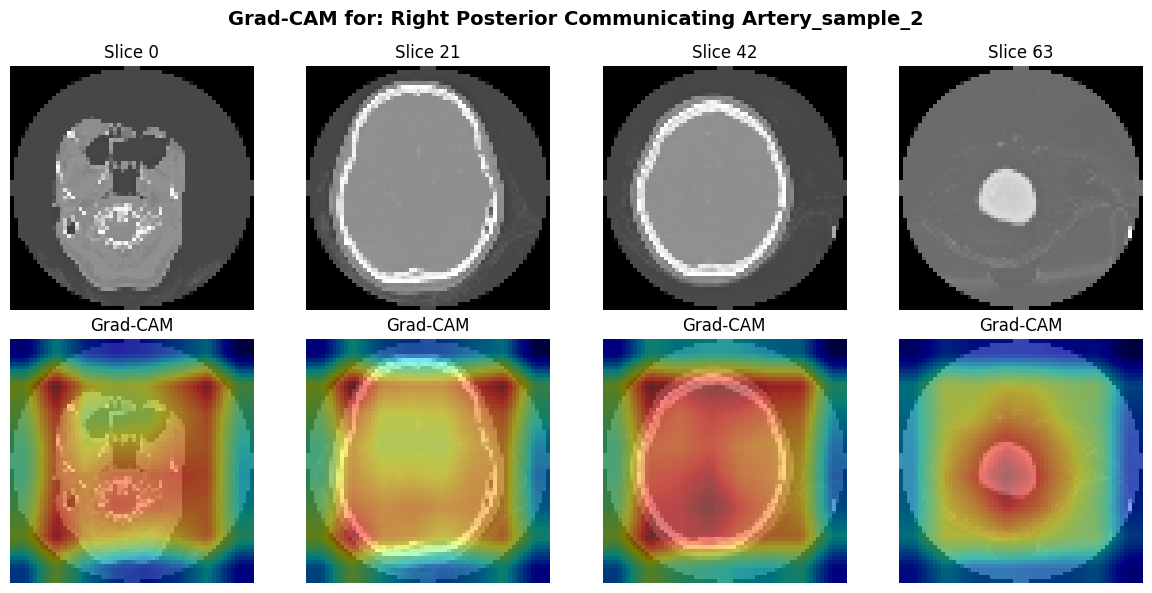

  Generating Grad-CAM for: Basilar Tip


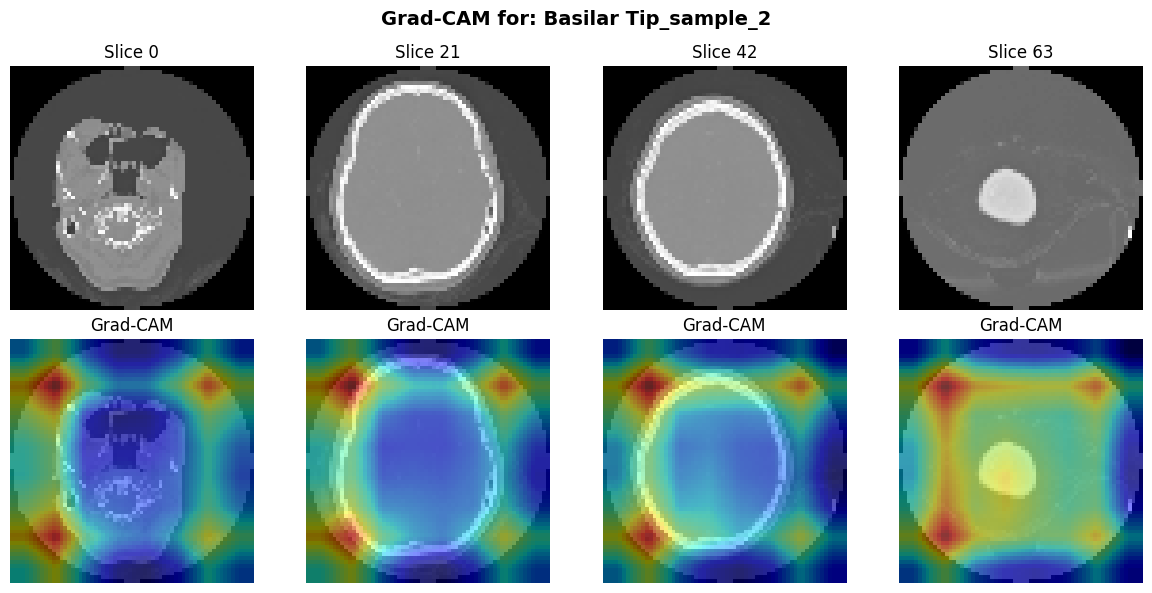

  Generating Grad-CAM for: Other Posterior Circulation


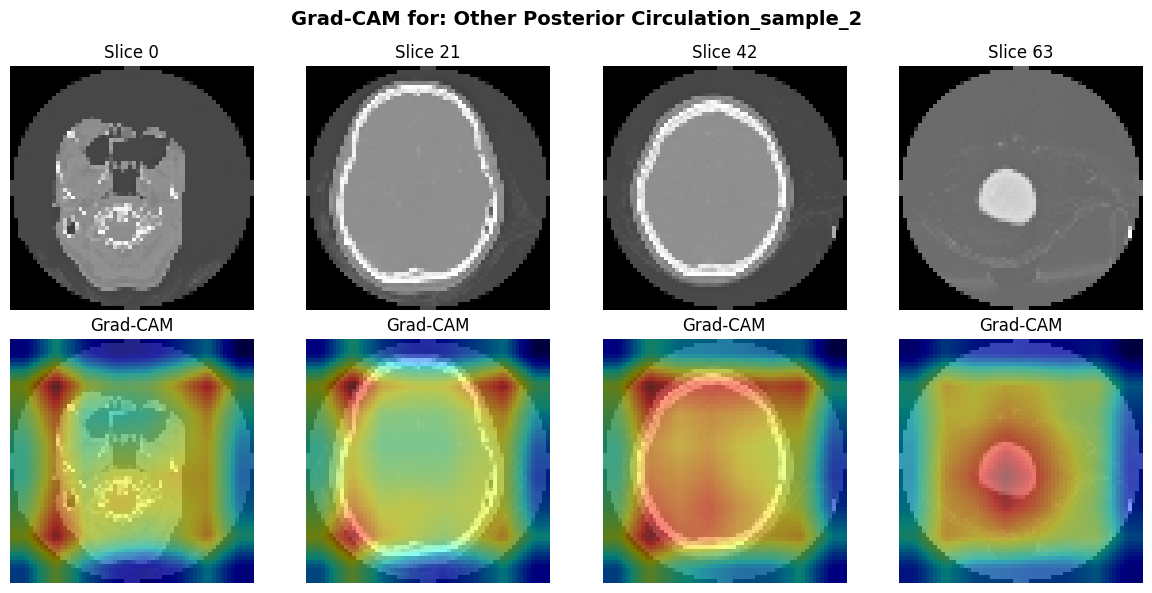

  Generating Grad-CAM for: Aneurysm Present


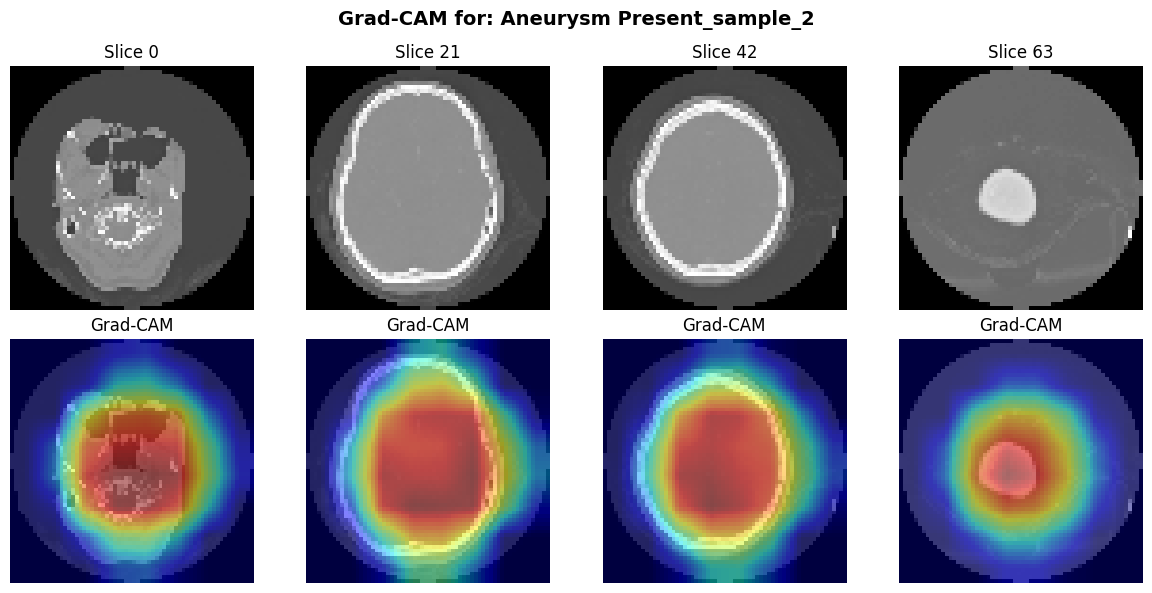


=== Generating Grad-CAM for Sample 3/4 ===
Ground truth labels: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  Generating Grad-CAM for: Left Infraclinoid Internal Carotid Artery


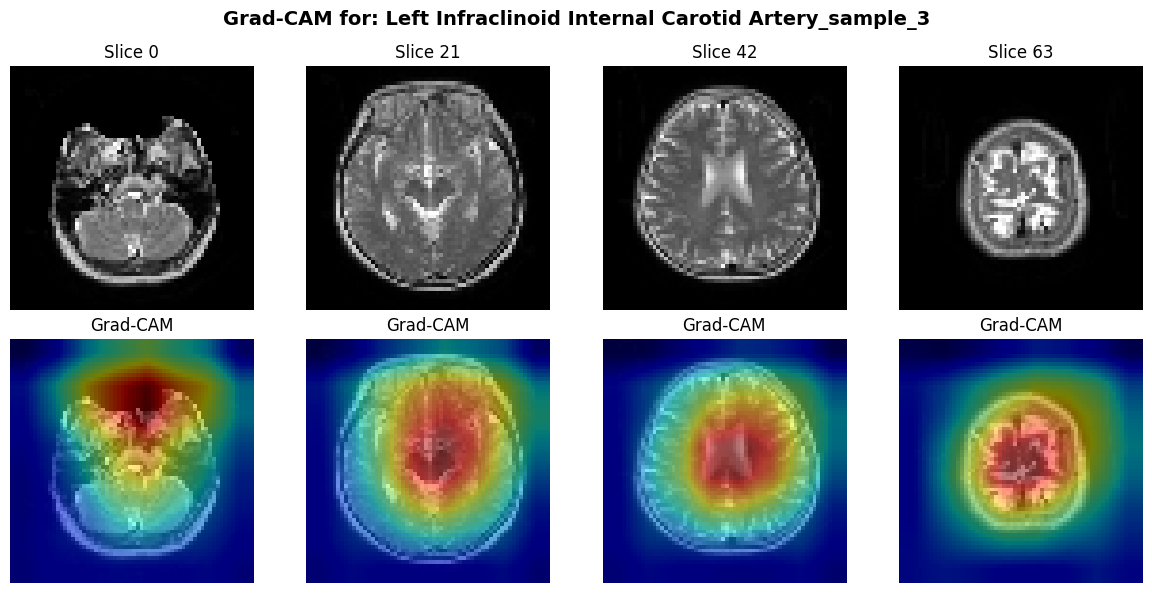

  Generating Grad-CAM for: Right Infraclinoid Internal Carotid Artery


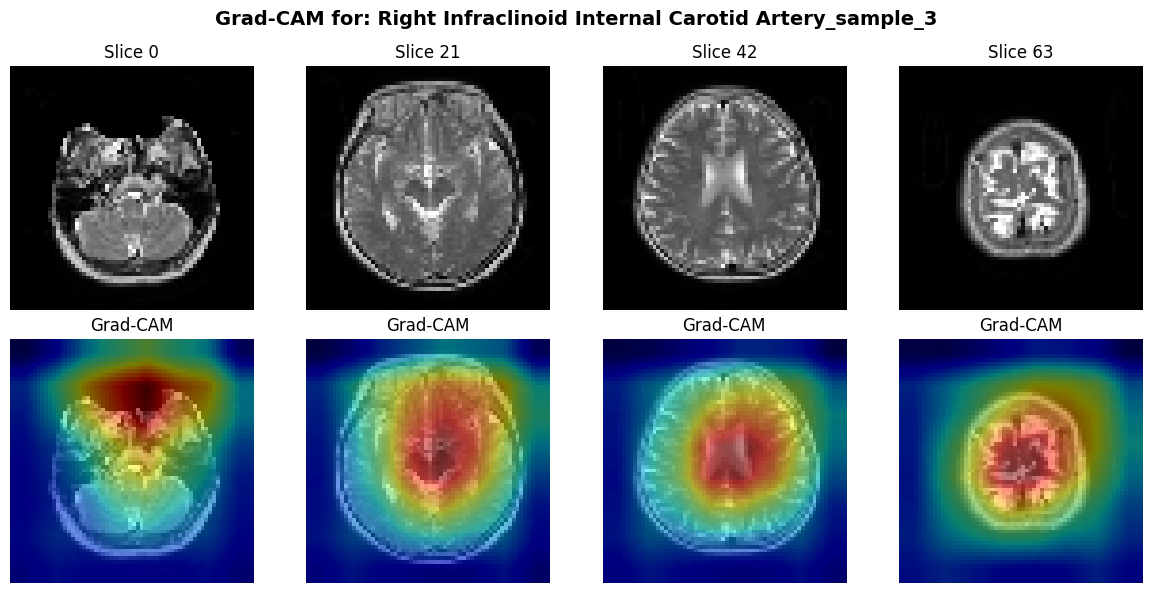

  Generating Grad-CAM for: Left Supraclinoid Internal Carotid Artery


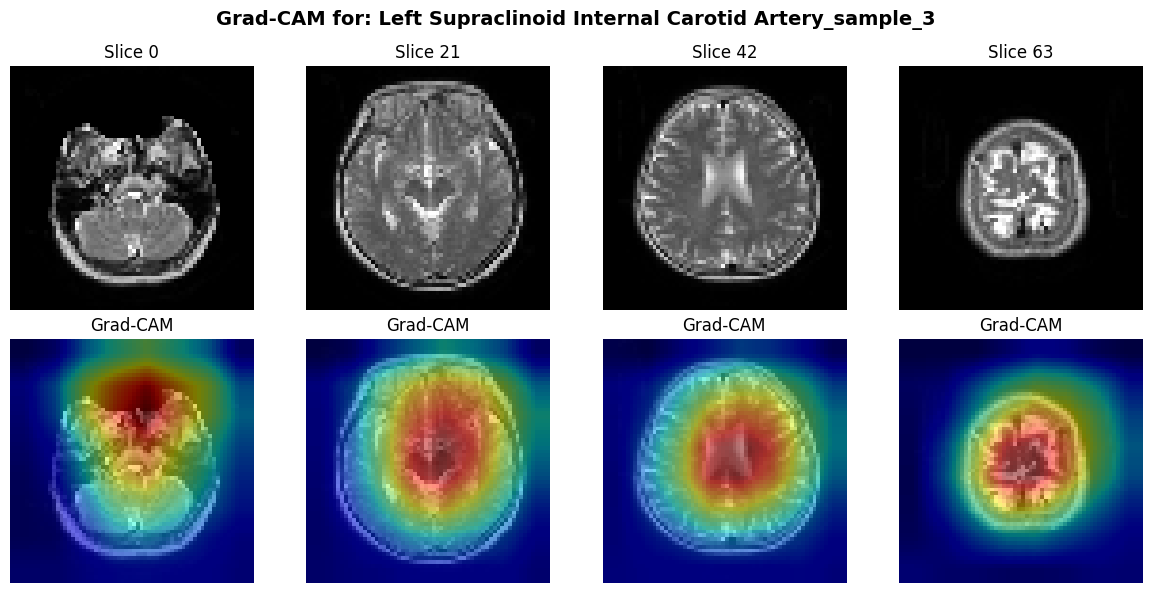

  Generating Grad-CAM for: Right Supraclinoid Internal Carotid Artery


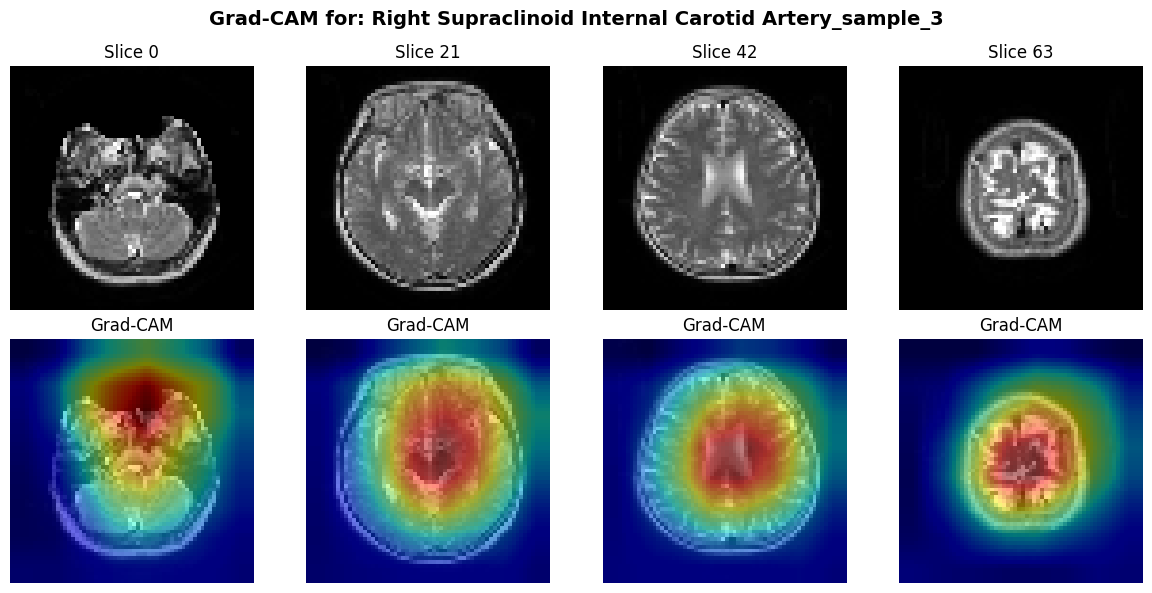

  Generating Grad-CAM for: Left Middle Cerebral Artery


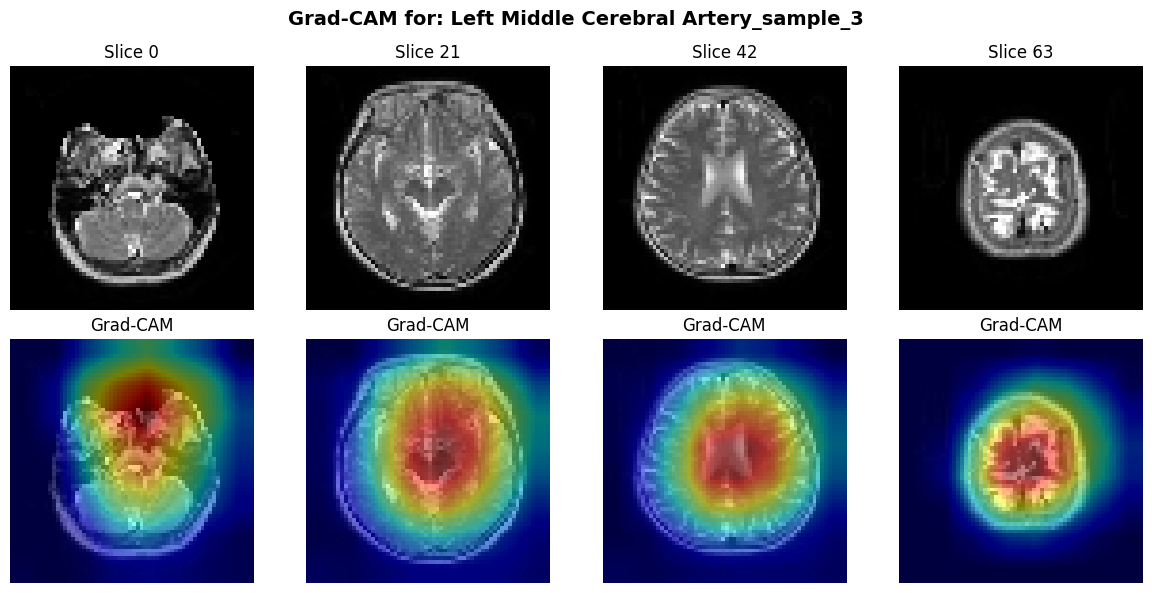

  Generating Grad-CAM for: Right Middle Cerebral Artery


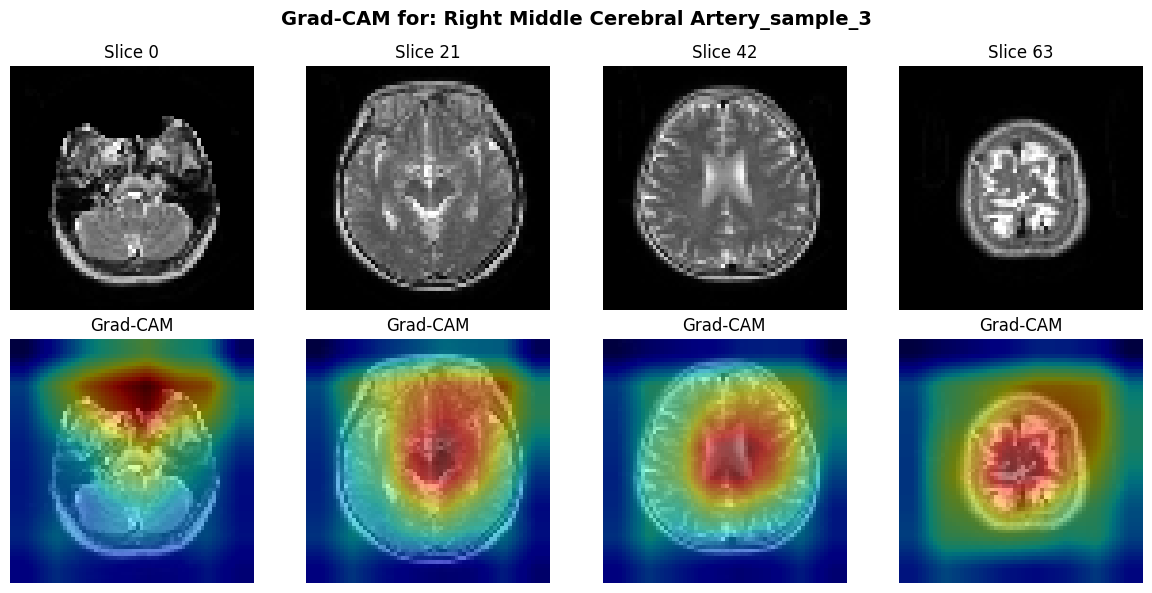

  Generating Grad-CAM for: Anterior Communicating Artery


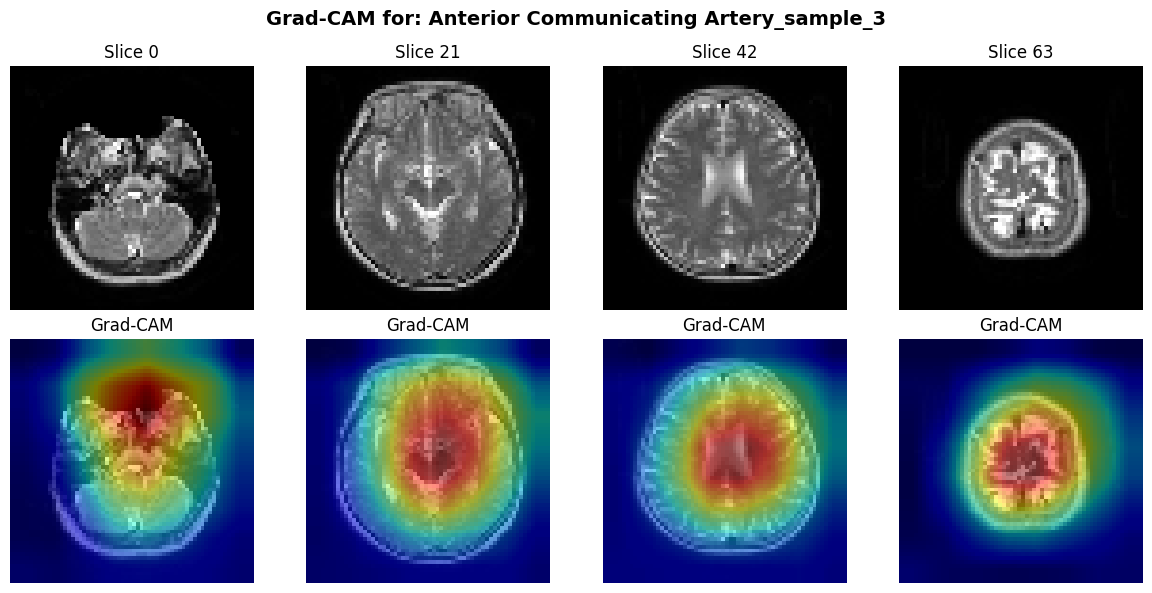

  Generating Grad-CAM for: Left Anterior Cerebral Artery


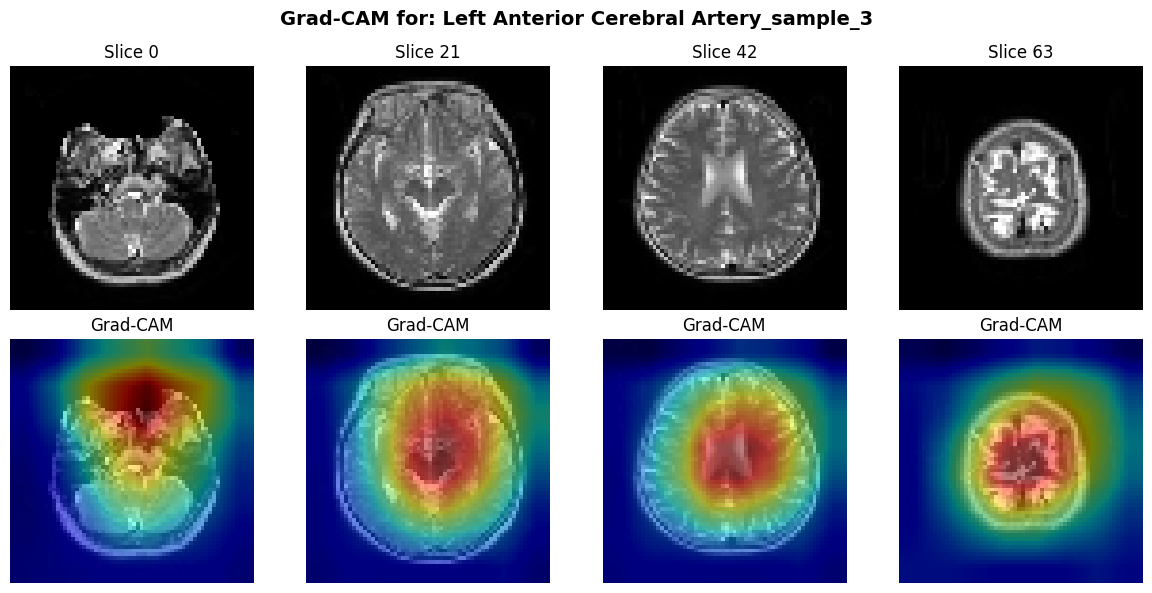

  Generating Grad-CAM for: Right Anterior Cerebral Artery


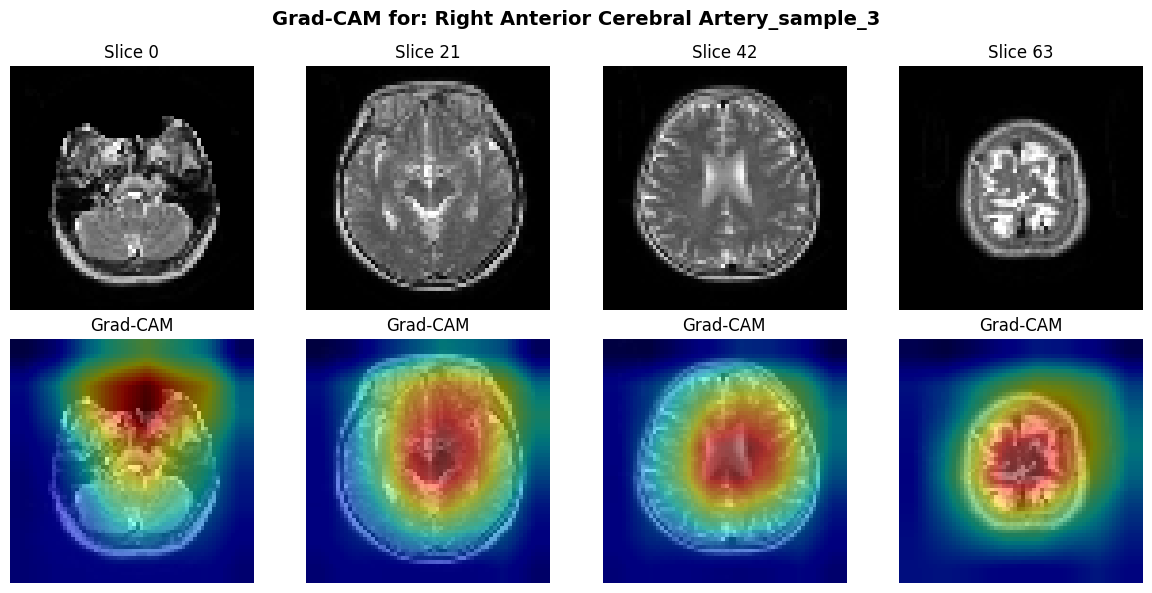

  Generating Grad-CAM for: Left Posterior Communicating Artery


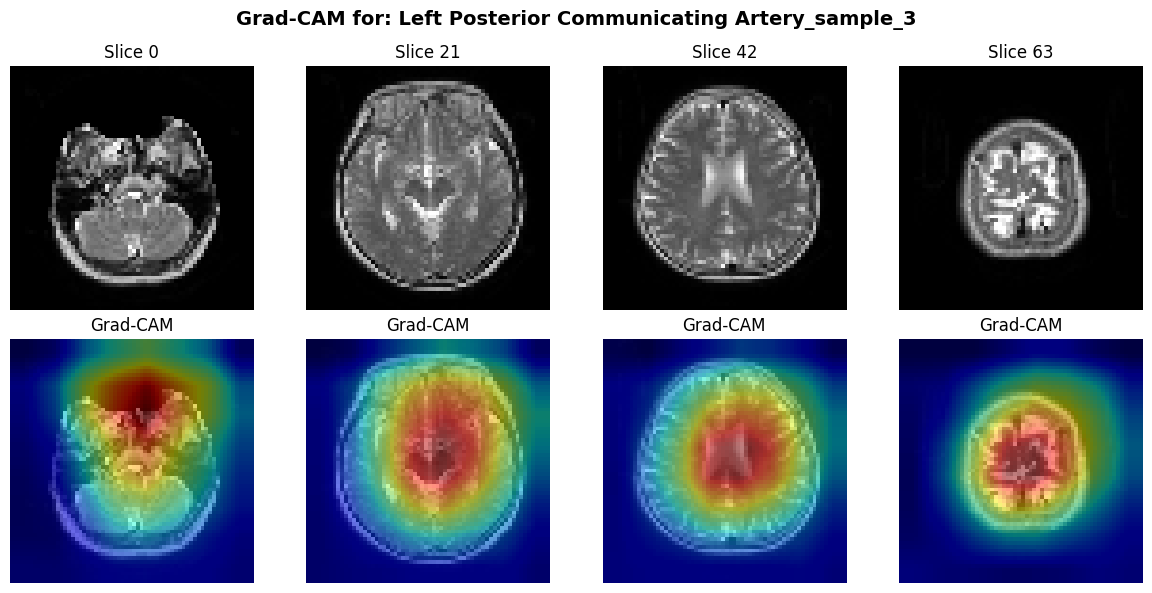

  Generating Grad-CAM for: Right Posterior Communicating Artery


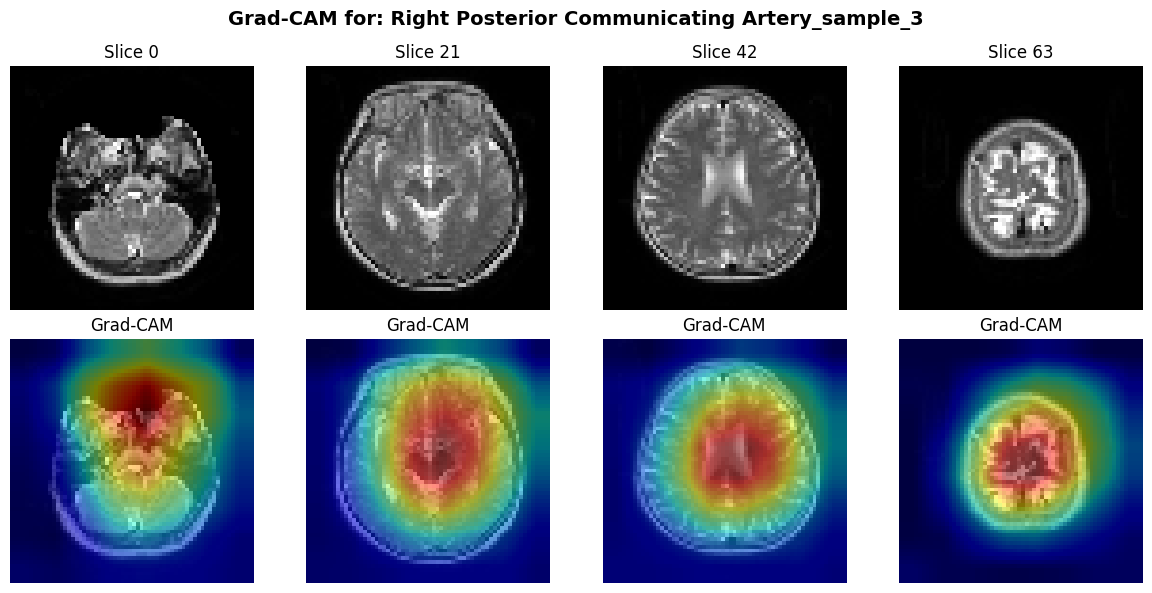

  Generating Grad-CAM for: Basilar Tip


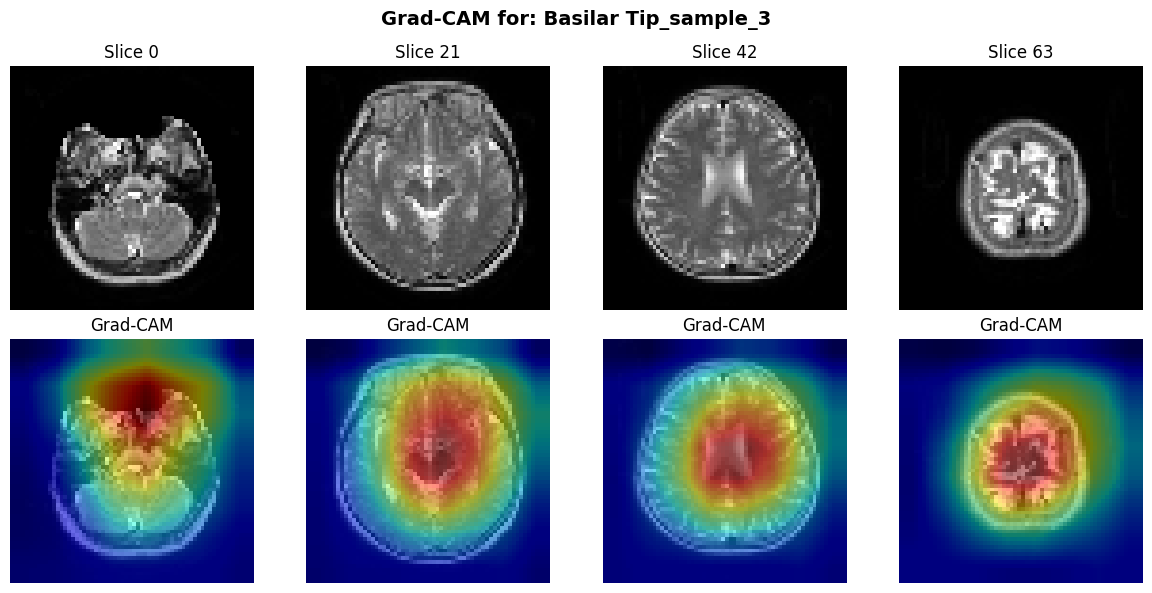

  Generating Grad-CAM for: Other Posterior Circulation


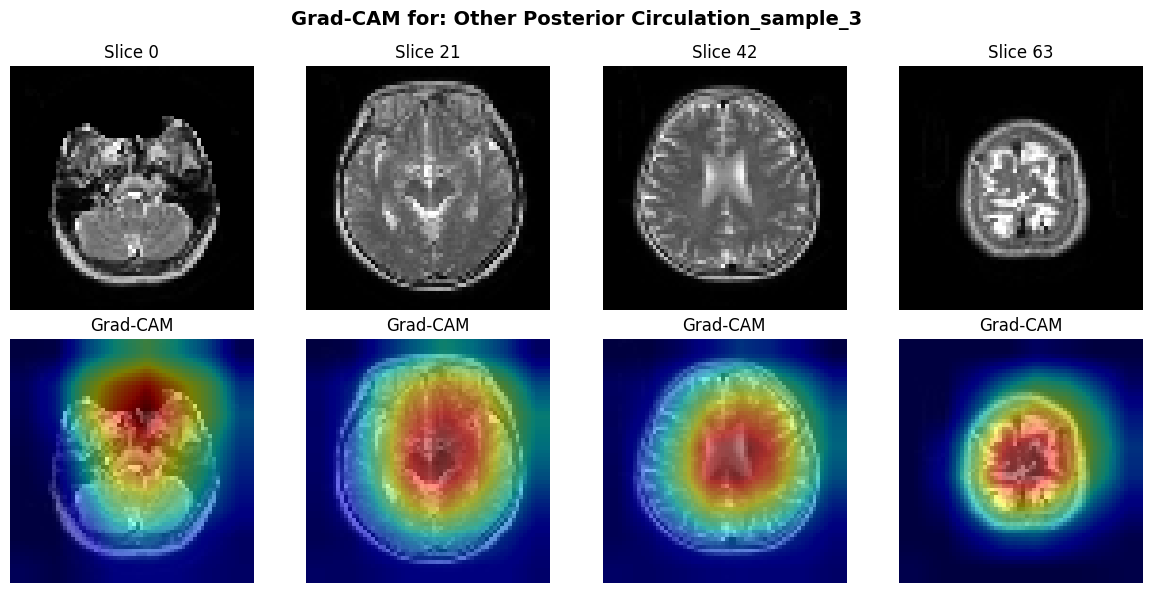

  Generating Grad-CAM for: Aneurysm Present


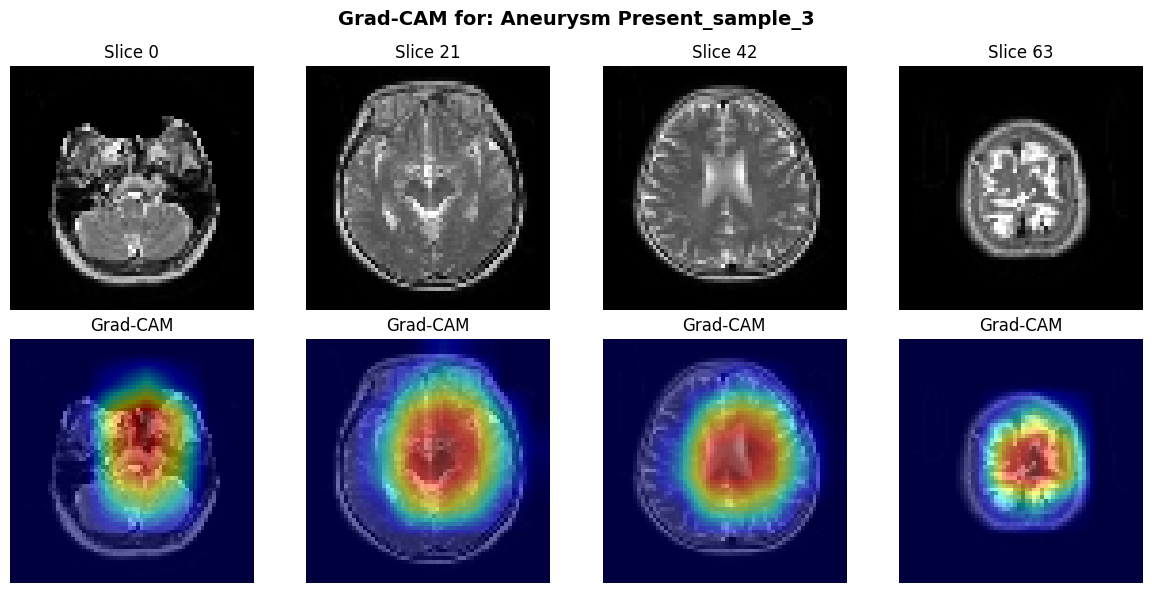


=== Generating Grad-CAM for Sample 4/4 ===
Ground truth labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Generating Grad-CAM for: Left Infraclinoid Internal Carotid Artery


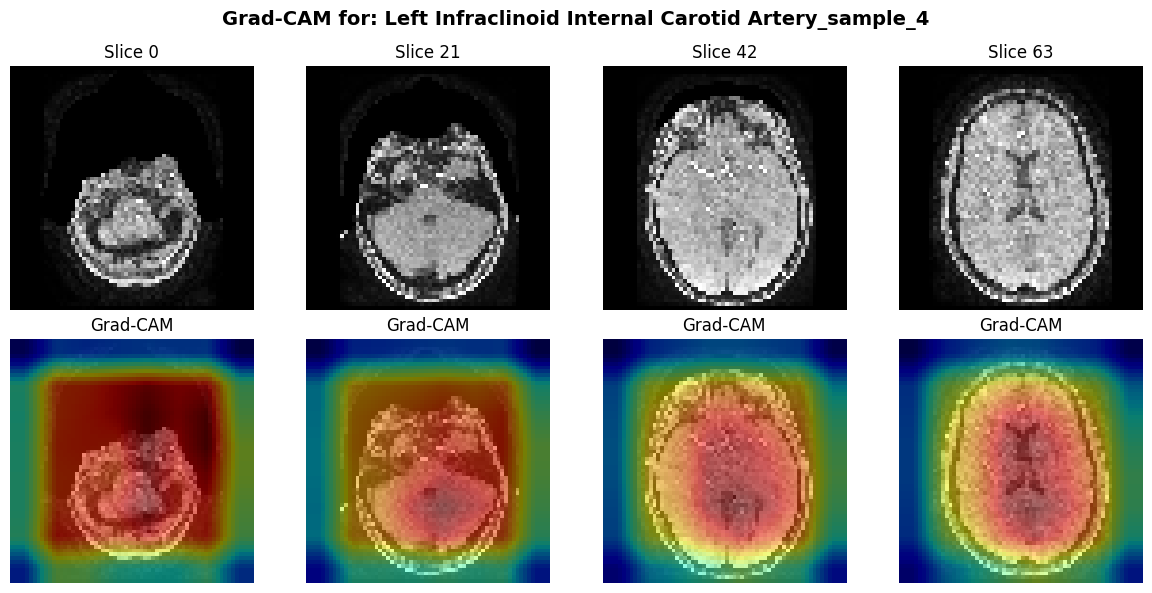

  Generating Grad-CAM for: Right Infraclinoid Internal Carotid Artery


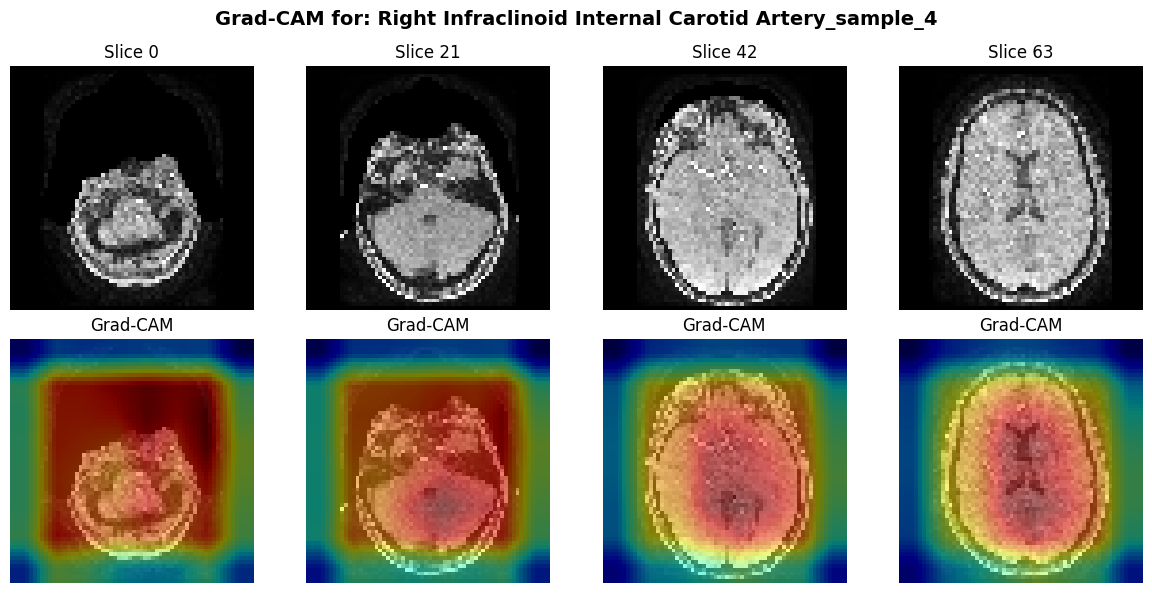

  Generating Grad-CAM for: Left Supraclinoid Internal Carotid Artery


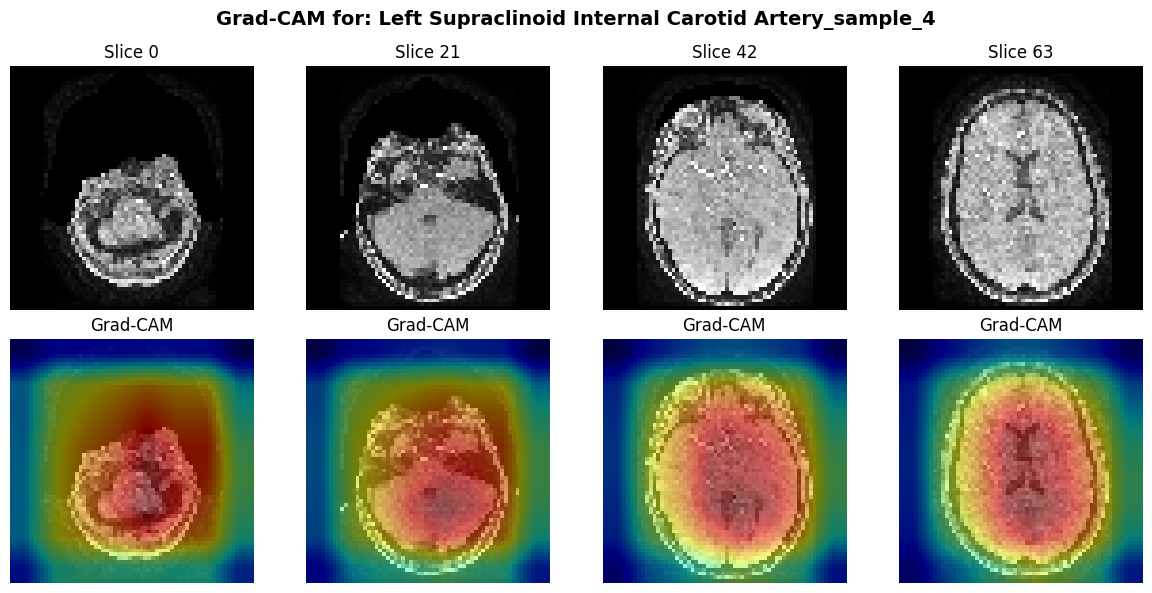

  Generating Grad-CAM for: Right Supraclinoid Internal Carotid Artery


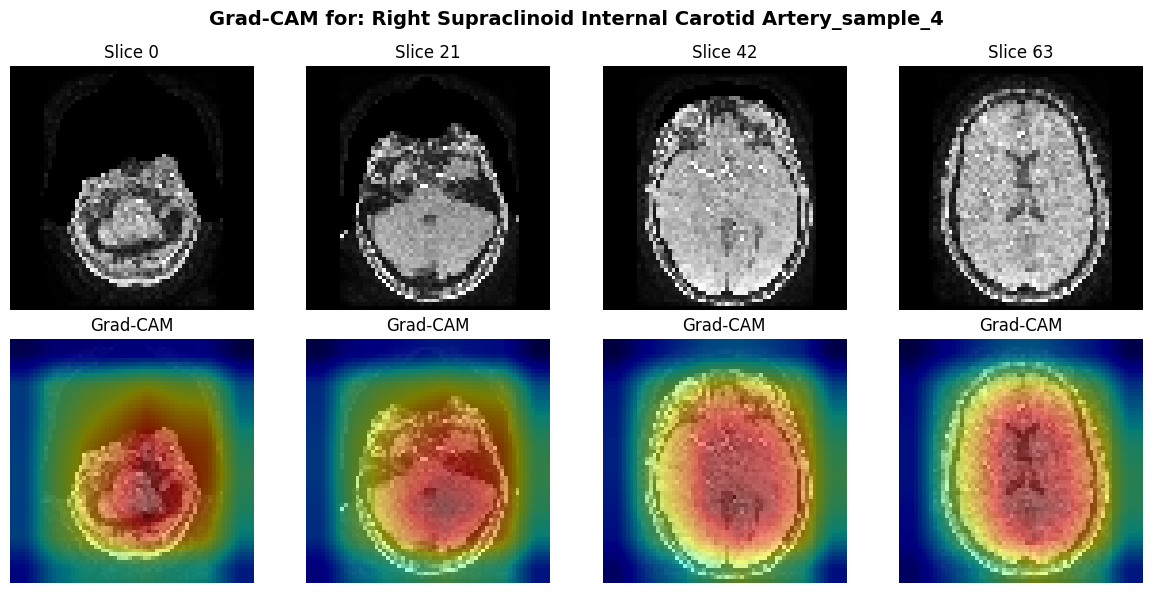

  Generating Grad-CAM for: Left Middle Cerebral Artery


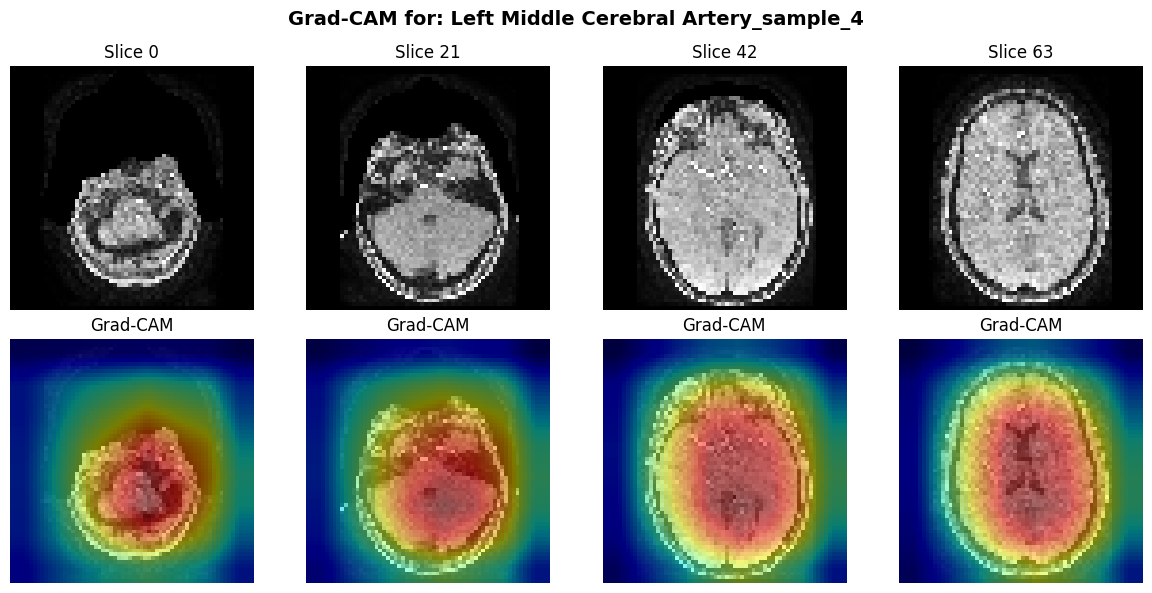

  Generating Grad-CAM for: Right Middle Cerebral Artery


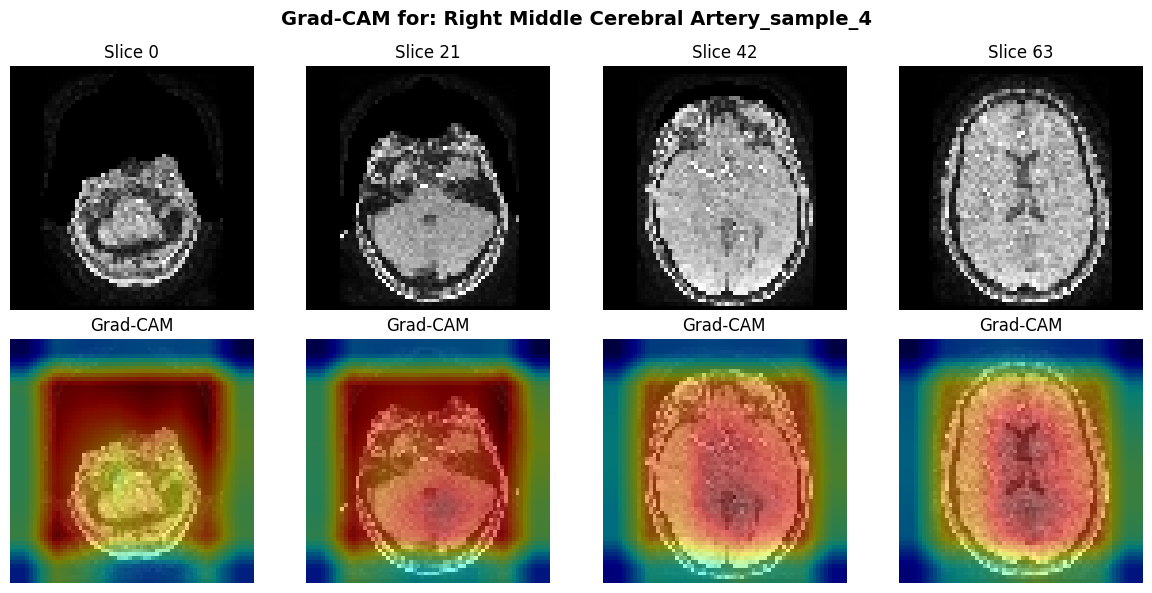

  Generating Grad-CAM for: Anterior Communicating Artery


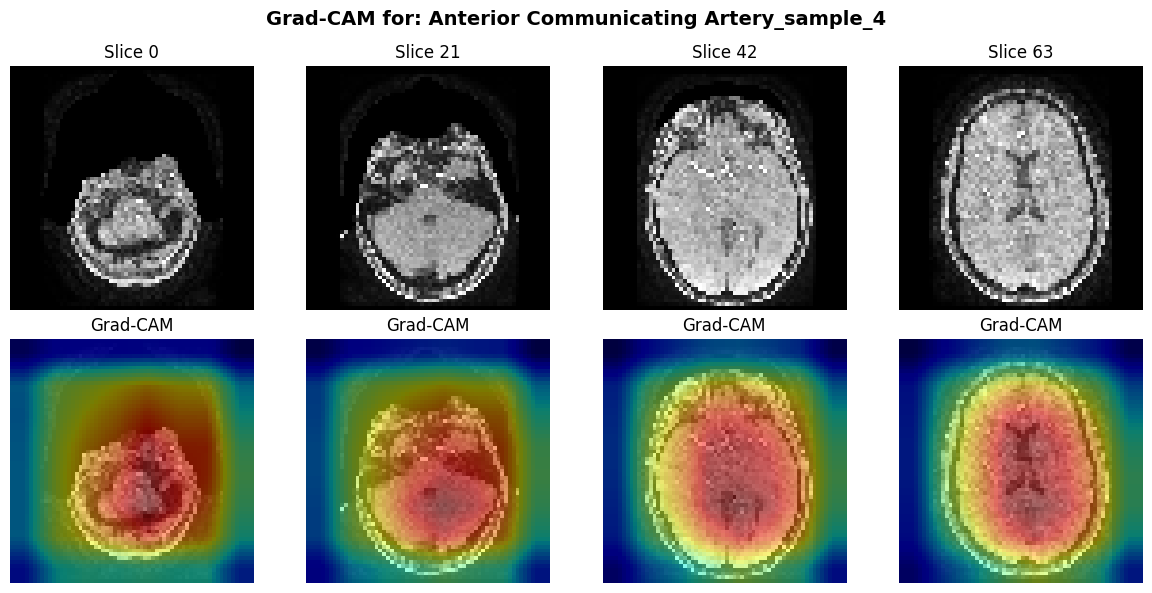

  Generating Grad-CAM for: Left Anterior Cerebral Artery


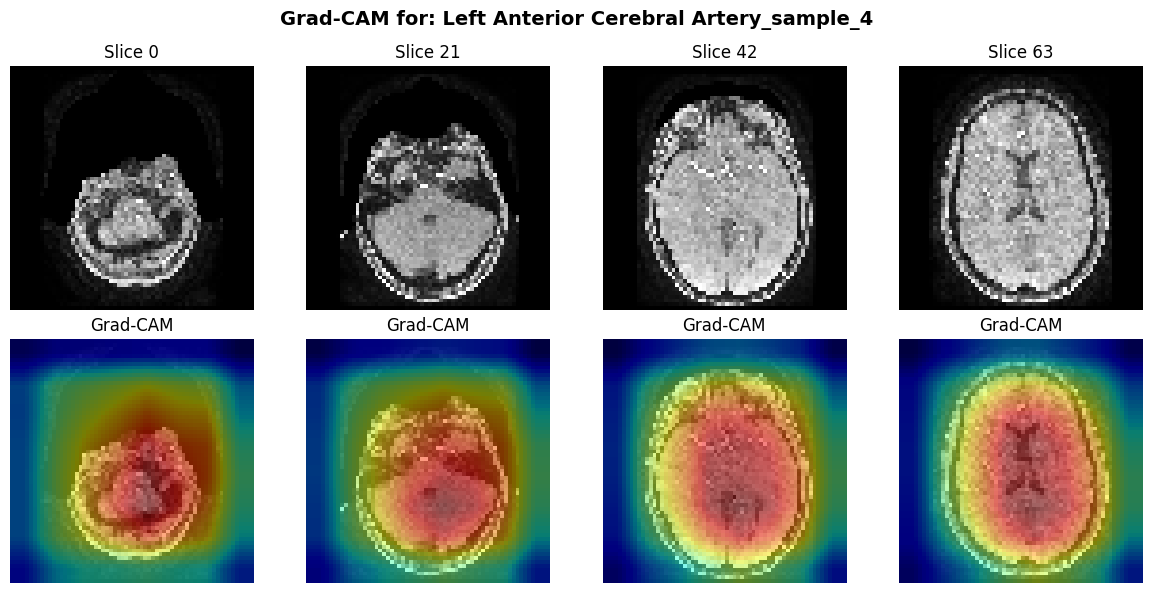

  Generating Grad-CAM for: Right Anterior Cerebral Artery


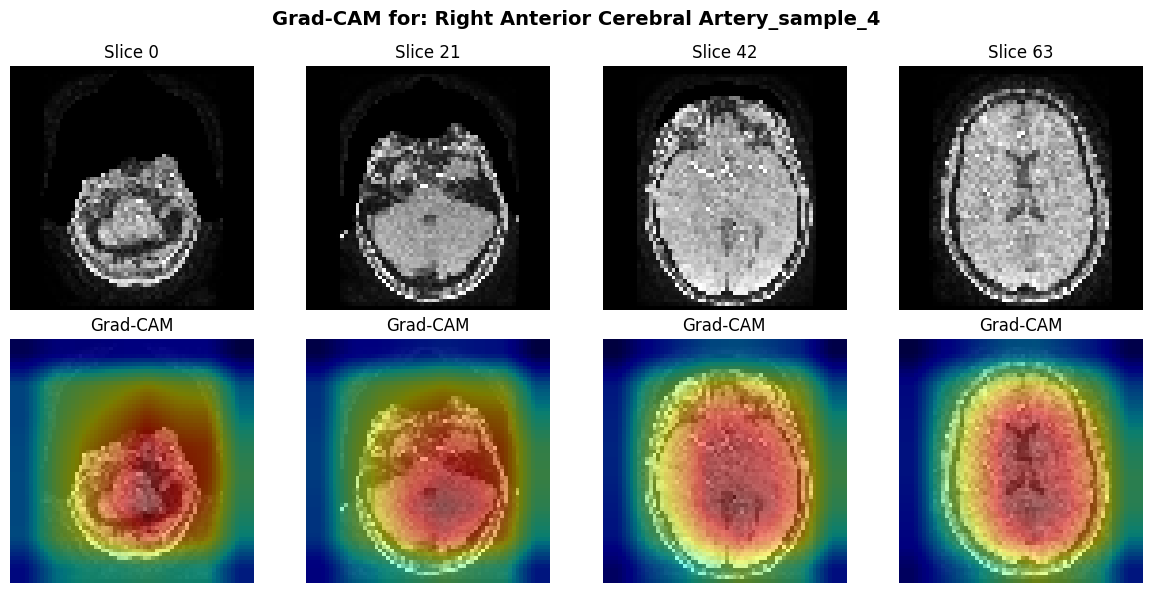

  Generating Grad-CAM for: Left Posterior Communicating Artery


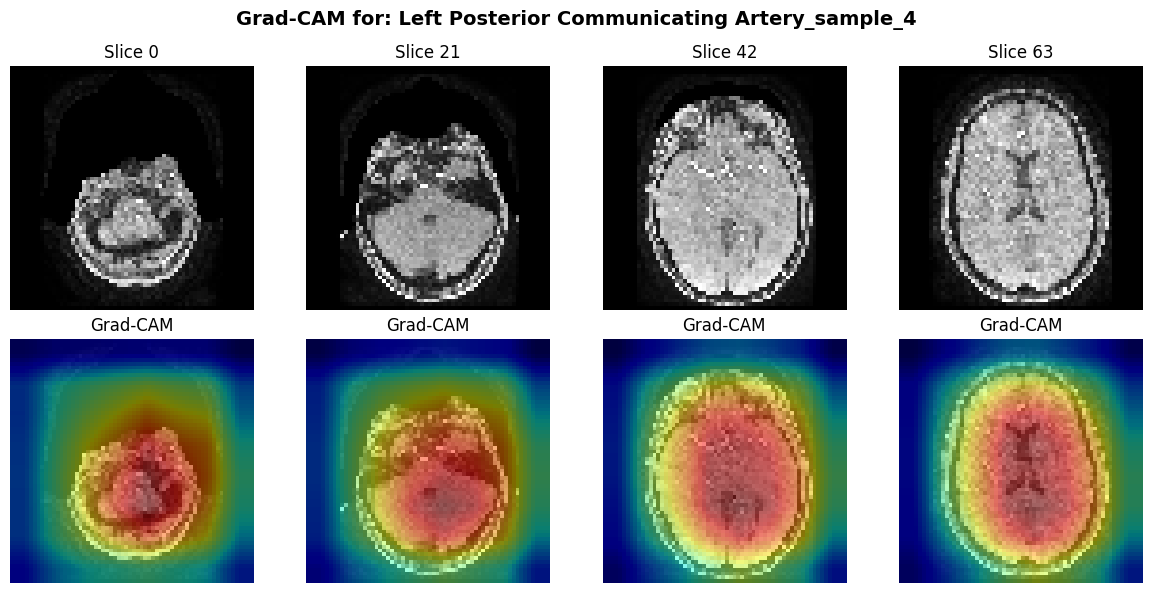

  Generating Grad-CAM for: Right Posterior Communicating Artery


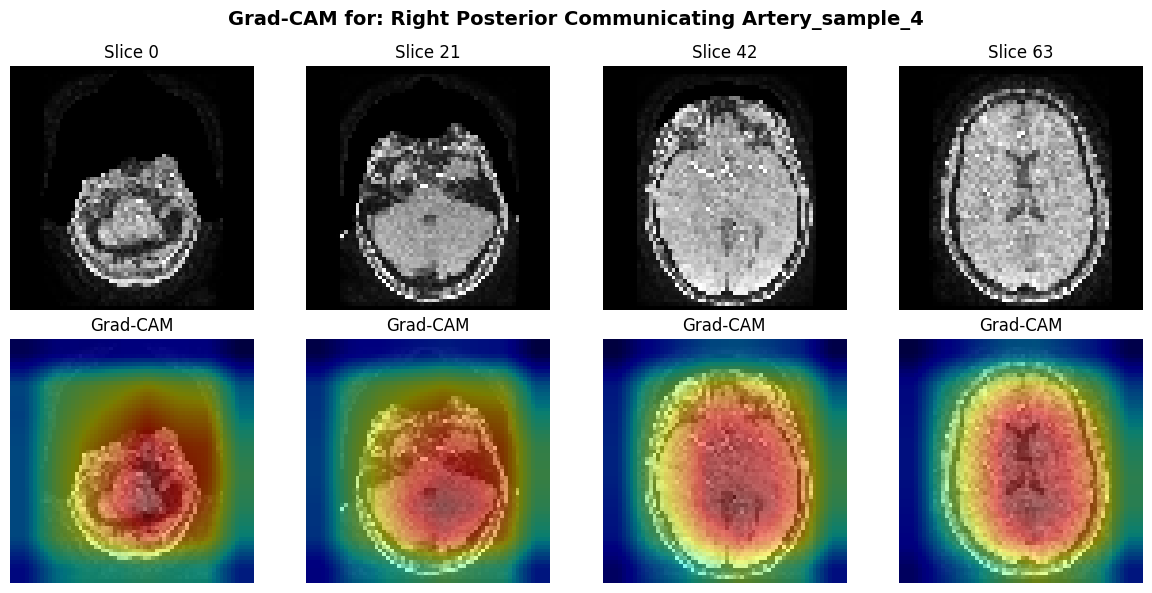

  Generating Grad-CAM for: Basilar Tip


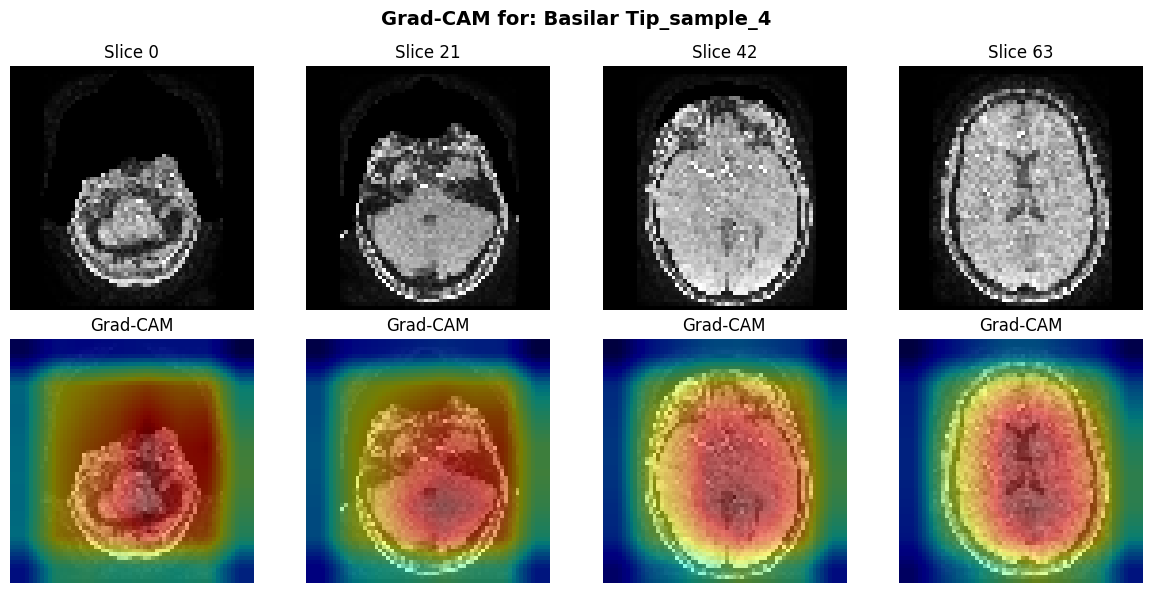

  Generating Grad-CAM for: Other Posterior Circulation


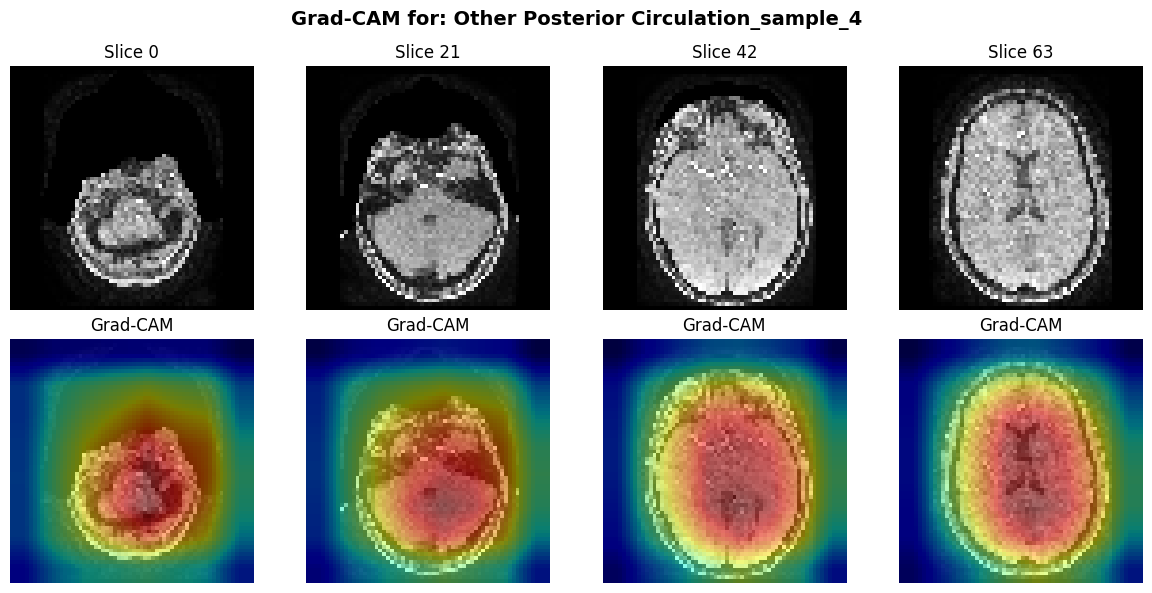

  Generating Grad-CAM for: Aneurysm Present


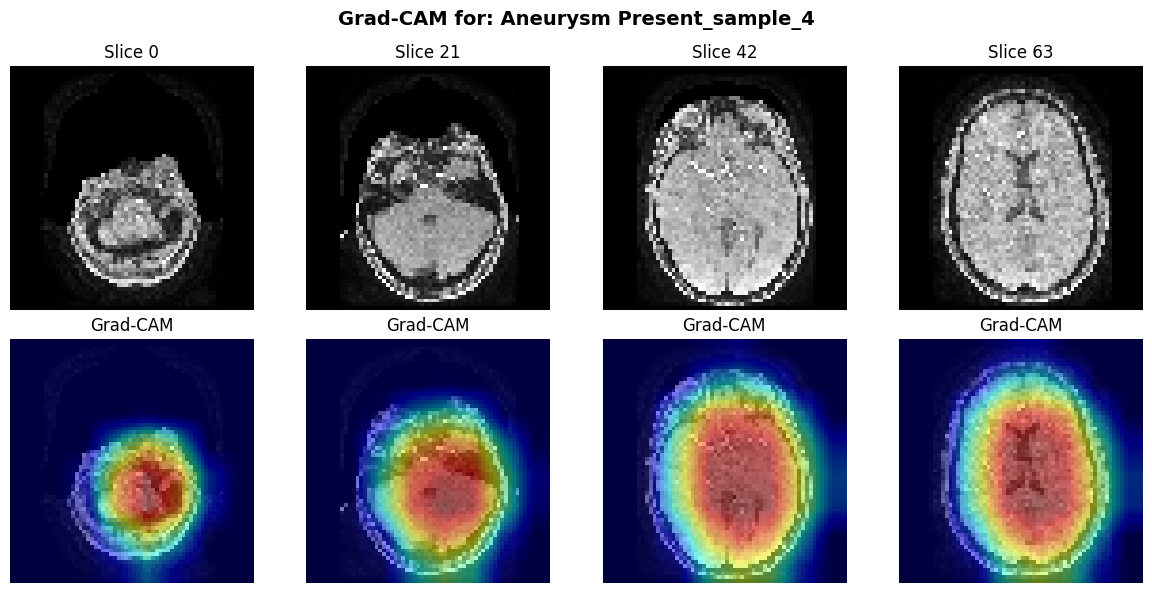


=== Grad-CAM Visualization Complete ===


In [14]:
print(f"Using device: {DEVICE}")
val_metrics, test_metrics = train_val_test_pipeline()

In [15]:
print("training complete")

training complete


In [16]:
!pip install torchviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [17]:
from torchviz import make_dot

model = Simple3DCNN(num_classes=NUM_CLASSES).to(DEVICE)
dummy_input = torch.randn(1, 1, 64, 64, 64).to(DEVICE)  # (B, C, D, H, W)

output = model(dummy_input)
dot = make_dot(output, params=dict(list(model.named_parameters())))
dot.format = "png"  # or "pdf"
dot.render("/kaggle/working/simple3dcnn_architecture")

'/kaggle/working/simple3dcnn_architecture.png'

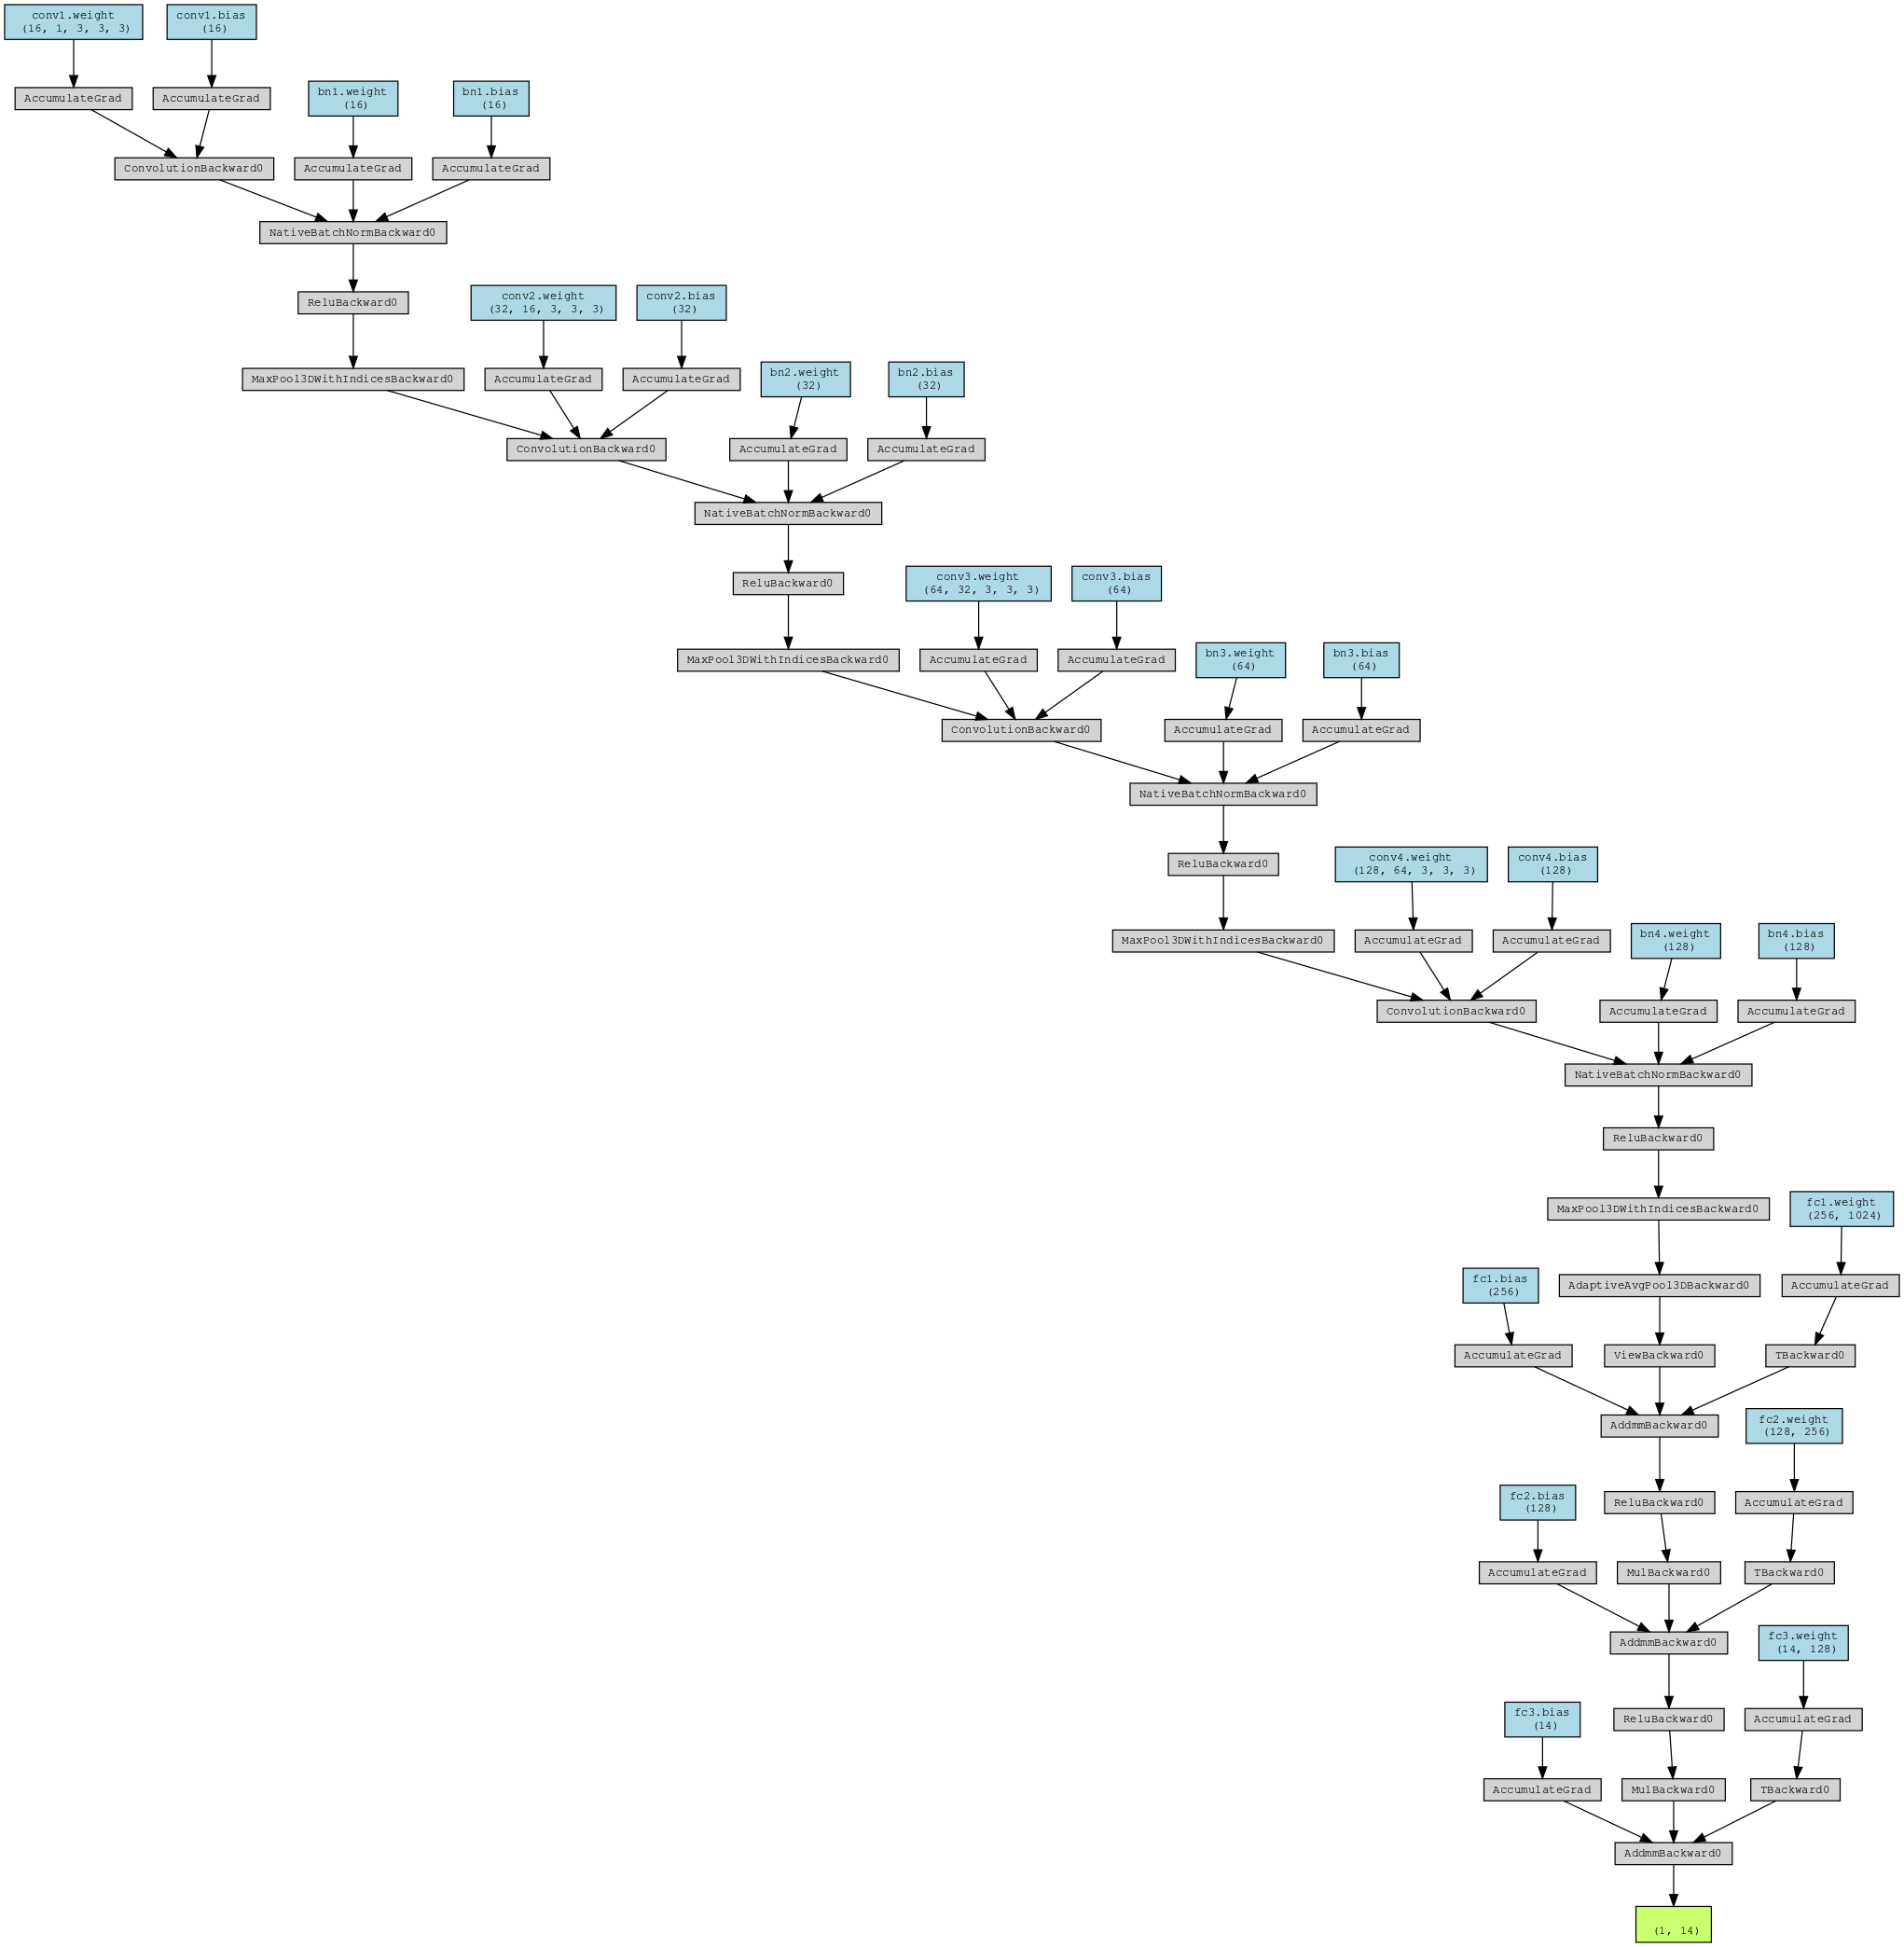

In [20]:
from IPython.display import Image, display
display(Image( "/kaggle/working/simple3dcnn_architecture.png"))

In [21]:
!pip install torchinfo

In [23]:
from torchinfo import summary
model = Simple3DCNN(num_classes=NUM_CLASSES).to(DEVICE)
summary(model, input_size=(1, 1, 64, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Simple3DCNN                              [1, 14]                   --
├─Conv3d: 1-1                            [1, 16, 64, 64, 64]       448
├─BatchNorm3d: 1-2                       [1, 16, 64, 64, 64]       32
├─MaxPool3d: 1-3                         [1, 16, 32, 32, 32]       --
├─Conv3d: 1-4                            [1, 32, 32, 32, 32]       13,856
├─BatchNorm3d: 1-5                       [1, 32, 32, 32, 32]       64
├─MaxPool3d: 1-6                         [1, 32, 16, 16, 16]       --
├─Conv3d: 1-7                            [1, 64, 16, 16, 16]       55,360
├─BatchNorm3d: 1-8                       [1, 64, 16, 16, 16]       128
├─MaxPool3d: 1-9                         [1, 64, 8, 8, 8]          --
├─Conv3d: 1-10                           [1, 128, 8, 8, 8]         221,312
├─BatchNorm3d: 1-11                      [1, 128, 8, 8, 8]         256
├─MaxPool3d: 1-12                        [1, 128, 4, 4, 4]         --